# Title to success (RandAda Milestone 3)

This notebook is an analysis of movie title features to determine whether the success of a movie can be predicted based on these features. 

We have loaded and preprocessed the data, conducted a time series analysis on selected features, and investigated the influence of five confounders. We then conducted a thorough investigation of five features: the title length in characters, the presence of a protagonist name, the grammar, the presence of proper nouns and the lexical fields. Our analysis includes both initial statistics and plots, as well as more in-depth analysis using correlation tests. As different film genres have different title characteristics and success, we created lexical fields for each film genre using NLP. Finally, we designed a prediction tool using random forest, which takes into account the predicted movie genre as a feature. 

Through this analysis, we have gained valuable insights on movie title semantics. However, we found out that the movie title did not provide enough insights to predict the movie success, with confounders such as actors or production studio having too great an influence.

**Contents of notebook:**

- [1 - Dataset pre-processing](#1---dataset-pre-processing)
  - [1.1 - Language filtering](#11---language-filtering)
  - [1.2 - Temporal distribution](#12---temporal-distribution)
  - [1.3 - Genre processing](#13---genre-processing)
  - [1.4 - Character metadata processing](#14---character-metadata-processing)
- [2 - First visualizations: insights on the evolution of title features over time](#2---first-visualizations-insights-on-the-evolution-of-title-features-over-time)
  - [2.1 - Title length in words and characters](#21---title-length-in-words-and-characters)
  - [2.2 - Sentiment analysis](#22---sentiment-analysis)
  - [Plots - Month](#23---part-of-speech-analysis-proper-nouns)
- [3 - Analysis of success confounders](#3---analysis-of-success-confounders)
  - [3.1 - Financial data preprocessing](#31---financial-data-pre-processing)
  - [3.2 - Famous actors](#32---famous-actors)
  - [3.3 - Famous production studios](#33---famous-production-studios)
  - [3.4 - Famous directors](#34---famous-directors)
  - [3.5 - Budget](#35---budget)
  - [3.6 - Movie genre](#36---movie-genre)
- [4 - Analysis of the influence of title key features on success](#4---analysis-of-the-influence-of-title-key-features-on-success)

# TO DO : continue the table of contents w links

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np
import string
import json
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from sci_analysis import analyze
from scipy.stats import ttest_ind
import plotly.express as px

# 1 - Dataset pre-processing

The CMU dataset contains very different types of movies, from 10-minute 1920s clip to modern Marvel movies.

We chose to focus on **feature films**, and thus to analyze only movies that last for more than one hour. The term feature film originally referred to the main, full-length film in a cinema program that included a short film and often a newsreel [Wikipedia](https://en.wikipedia.org/wiki/Feature_film).

We will perform those two first steps :
- Remove movies for which we don't have the title
- Select only full-length feature (movies of more than one hour long)

In [2]:
character_metadata = pd.read_csv('Data/character.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_release_date',
                                                                              'Character_name',
                                                                              'Actor_date_of_birth',
                                                                              'Actor_gender',
                                                                              'Actor_height',
                                                                              'Actor_ethnicity',
                                                                              'Actor_name',
                                                                              'Actor_age_at_movie_release',
                                                                              'Freebase_character/actor_map_ID',
                                                                              'Freebase_character_ID',
                                                                              'Freebase_actor_ID'])

movie_metadata = pd.read_csv('Data/movie.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_name',
                                                                              'Movie_release_date',
                                                                              'Movie_box_office_revenue',
                                                                              'Movie_runtime',
                                                                              'Movie_languages',
                                                                              'Movie_countries',
                                                                              'Movie_genres'])

plot_summaries = pd.read_csv('Data/plot_summaries.txt', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'summary'])

In [3]:
#Copy of movie_metadata dataset
movie_metadata_readable = movie_metadata.copy(deep= True)

# Make the column Movie_languages, Movie_countries and Movie_genres more readable (i.e change as list)

def readable(column):
    pd.set_option('mode.chained_assignment', None) #remove warning
    for i in column.index:
        d=json.loads(column[i]) #change set of each row from the colomn to dict
        column[i]=list(d.values()) #change the dict into list

readable(movie_metadata_readable['Movie_languages'])
readable(movie_metadata_readable['Movie_countries'])
readable(movie_metadata_readable['Movie_genres'])

movie_metadata_readable.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [4]:
#Filtering of movie_metada, keeping only full-length features movies (more than 60 minutes long) and that have a Title in the database.
movie_metadata_filtered = movie_metadata_readable.copy(deep=True)
print(f"Number of movies in the database before the first cleaning step: {movie_metadata_filtered['Movie_release_date'].size}.")


movie_metadata_filtered.dropna(subset=['Movie_name'],inplace=True)

movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_runtime >= 60]


#Cleaning of the Movie_release_date column, to keep only the year of release
movie_metadata_filtered.dropna(subset=['Movie_release_date'], inplace = True)
movie_metadata_filtered["Movie_release_date"] = movie_metadata_filtered['Movie_release_date'].apply(lambda x : str(x)[:4]).apply(lambda x : int(x))


print(f"Number of movies in the database after this first cleaning step: {movie_metadata_filtered['Movie_release_date'].size}.")

Number of movies in the database before the first cleaning step: 81741.
Number of movies in the database after this first cleaning step: 52286.


## 1.1 - Language filtering
We aim to filter the dataset to keep movies with English title. In fact, the NLP packages are mostly developed for English language. To do this easily we only select movies that have English as main language (as they should also have an English title).

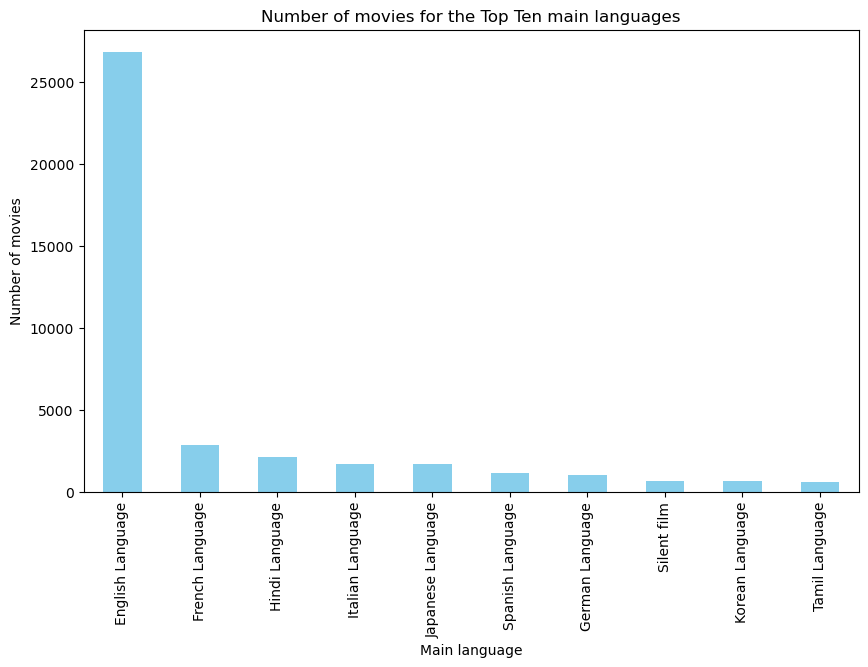

In [5]:
#Movie distribution per languages: top ten main languages

movie_metadata_filtered['Movie_main_language'] = movie_metadata_filtered.Movie_languages.str[0]
movie_metadata_filtered['Movie_main_language'] = movie_metadata_filtered.Movie_main_language.astype('category')

# Create a DataFrame with feature counts
main_languages = movie_metadata_filtered['Movie_main_language'].value_counts()

# Select the top ten features
top_ten_main_languages = main_languages.head(10)

# Plot the bar plot
plt.figure(figsize=(10, 6))
top_ten_main_languages.plot(kind='bar', color='skyblue')
plt.title('Number of movies for the Top Ten main languages')
plt.xlabel('Main language')
plt.ylabel('Number of movies')
plt.show()



In [6]:
#Create dataset with filtered language:  english as first language
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_main_language=="English Language"] #English Language as First Language

print(f"Number of movies in the database after the language filtering: {movie_metadata_filtered['Movie_release_date'].size}.")

Number of movies in the database after the language filtering: 26855.


After the removal of the shortest movies and of movies without title, 52'286 movies remain. 51.3%  of them (26'855) are in English. 
Thus, keeping only the movies in English does not reduce too much the size of the whole database.

## 1.2 - Temporal distribution

Let's explore our data. One first thing to look at is the temporal distribution of movies.

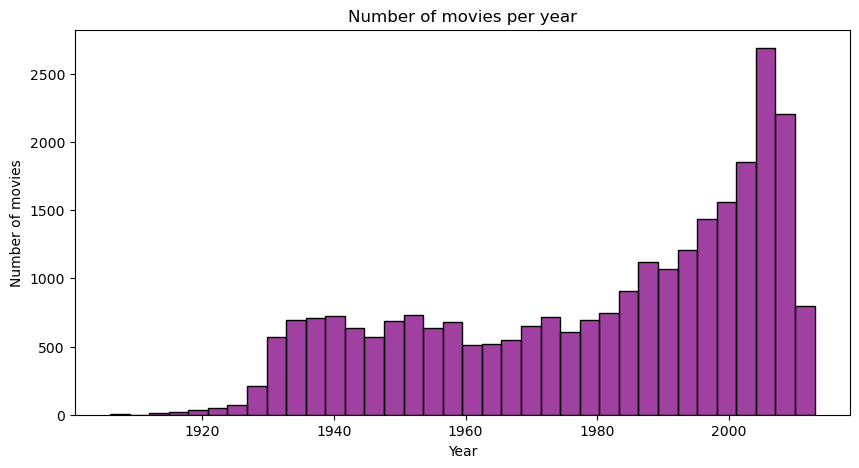

In [7]:
#Number of movies per year
plt.figure(figsize=(10,5))
ax = sns.histplot(movie_metadata_filtered,x='Movie_release_date',stat='count',color="purple").set(title="Number of movies per year",xlabel="Year",ylabel="Number of movies")

Our dataset was extracted in 2012. As a result, many movies released after 2012 are missing. Let's see how many movies have a release date after 2012.

In [8]:
movie_metadata_filtered[movie_metadata_filtered.Movie_release_date > 2012]

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_main_language
2942,29097142,/m/0dlk_qn,Movie 43,2013,NaN,175.0,[English Language],[United States of America],[Comedy],English Language
4676,34957039,/m/0j7mv7h,Postman Pat: The Movie — You Know You're The One,2013,NaN,117.0,[English Language],[United Kingdom],"[Family Film, Animation]",English Language
9447,3081811,/m/08q3xy,Sin City 2,2013,NaN,120.0,[English Language],[United States of America],"[Thriller, Crime Fiction, Superhero movie, Act...",English Language
13338,36120997,/m/0k0wrfg,Ned Venture,2013,NaN,90.0,[English Language],[United States of America],[Comedy film],English Language
14160,31106576,/m/0gh8bt9,Bullet to the Head,2013,NaN,97.0,[English Language],[United States of America],"[Thriller, Crime Fiction, Action]",English Language
16772,23468311,/m/06w6vd9,"Quick, Slip Me A Bride",2013,NaN,100.0,[English Language],[United Kingdom],[Romance Film],English Language
18210,34682342,/m/0j3d8n7,Calvary,2013,NaN,147.0,[English Language],"[Ireland, United Kingdom]","[Black comedy, Comedy film, Drama]",English Language
32241,34779274,/m/0j3f7xf,Viy. Returning,2013,NaN,112.0,"[English Language, Russian Language]","[Ukraine, Czech Republic, Russia]","[Thriller, Mystery, Horror, Adventure]",English Language
32338,35229863,/m/0j7m_4k,McConkey,2013,NaN,90.0,[English Language],[United States of America],"[Biographical film, Documentary]",English Language
32529,35720024,/m/0jt1g0l,Teen Beach Musical,2013,NaN,125.0,[English Language],[United States of America],"[Musical, Family Film]",English Language


We remove these movies released after 2012 to be consistent with the extraction date of the CMU database.

In [9]:
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_release_date <= 2012]

print(f"Number of movies in the database after the language filtering: {movie_metadata_filtered['Movie_release_date'].size}.")

Number of movies in the database after the language filtering: 26840.


## 1.3 - Genre processing

For our sentimental analysis using NLP, we may need to use movies genres as categories. We thus need to assign every movie in only one genre category (preferably the main genre, which is the first in the list). We thus created a more **"basic" dictionnary of genres** and assigned most categories to one of these "main/major" genres.

In [10]:
# For some of the categories we had to look for it and to look at the movies that had this genre to know it which categories we should put it in.

# 1st step: create a new genre dictionnary
dict_genre = {
    "Action": ["Action/adventure", "ninja movie", "epic", "auto racing", "martial arts film","Combat Films", "race movie", "samurai cinema", "Super hero", "superhero movie", "superhero","Outlaw biker film"],
    "Adventure": ["Adventure", "travel"],
    "Art": ["Art film","Concert film", "Film-Opera", "Operetta", "Punk rock", "Rockumentary", "Space opera", "Singing cowboy", "Hip hop movies", "Breakdance", "Dance", "musical", "& Literature", "Literature", "Music","Experimental film"],
    "Comedy": ["Humour", "Tragicomedy", "Ealing Comedies", "Comedy film","Comedy", "Adventure Comedy", "Comedy of manners", "Workplace comedy", "comedy-drama", "Buddy Picture", "Buddy cop", "Parody","Black comedy","Satire","Screwball comedy","Musical comedy","Buddy film","Mockumentary"], 
    "Documentary": ["Docudrama", "Historical Documentaries", "Rockumentary", "media studies", "media satire", "Political Documentary"],
    "Drama": ["Melodrama", "Tragedy", "Tragicomedy", "Docudrama", "Family drama", "Comedy-drama", 'illnesses & disabilities','Costume drama',"Political drama","Exploitation"], 
    "Political":[ "Political cinema","LGBT","Blaxploitation","Christian film","Culture & Society","Religious Film"], 
    "Family": ["Computer Animation","Coming of age","Family Film", "Animation", "Animated cartoon", "Children's film", "children's", "children's entertainment", "children's fantasy", "children's/family", "For children","Christmas movie","Television movie","Teen"], 
    "Fiction": ["Science Fiction","fairy tail", "fictional film", "medical fiction", "mythological fantasy", "sci fi pictures", 'sci fi pictures original films', "sword and sorcery films", "sword and sandal", "time travel", "supernatural", "Alien invasion","Alien Film", "Zombie film", "Z-movie", "z movie", "Zombie","Fantasy","Disaster","Fan film"],
    "Historical": ["Short Film","Historical fiction","Period piece","history", "Biographical", "British History", "British Empire Film", "British new wave", "Historical Epic", "Cold War", "Historical Documentaries", "Biography", "Biopic [feature]", "The Netherlands in World War II", "Gulf War", "movies about gladiators","Biographical film","Historical drama","Sponsored film"],
    "Horror": ["Natural Horror film", "Sci-fi Horror", "road-horror", "Creature Movie", "Monster Movie", "Creature","Slasher"],
    "Old movie":['Black-and-white',"Silent film"],
    "Porn": ["Pornographic movie", "Pornography", "Softcore Porn", "Adult", "Sexploitation", "Erotica", "homoeroticism", "erotic thriller", "Hardcore pornography", "Homoeroticism","Gay pornography"], 
    "Romance": ["Romance film", "romantic fantasy","Romantic comedy","Romantic drama","Pre-code"],
    "Sport": ["baseball", "boxing", "sports"],
    "Thriller": [ "film à clef", "mystery", "suspense", 'crime', 'crime fiction', 'crime thriller', "master criminal films", "detective", "Master Criminal Films", "Heist", "Gangster Film","Film noir","Psychological thriller","Detective fiction","Spy"],
    "Western": ["Singing cowboy", "Westerns", "B-Western", "Epic Western", "Spaghetti Western"],
    "World cinema": ["Northern","Chinese Movies", "Japanese Movies", "Latino", "americana", "bengali cinema", "filipino movies", "Anime", "Indie"],
    "War film": ["war", "War effort", "anti-war", "anti-war film", "nuclear warfare", "foreign legion"],
}

In [11]:
# 2nd step: Revert the current dictionnary, because it is easier to manipulate

dict_genre_revert = {}
for key, value in dict_genre.items():
    key = key.lower()
    for v in value:
        v = v.lower()
        dict_genre_revert[v] = key
    dict_genre_revert[key] = key

In [12]:
# Drop movie without genre (=emplty list in 'Movie_genres')
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered['Movie_genres'].map(lambda d: len(d)) > 0]

In [13]:
# 3rd step: Give main genre to each movie 

Main_genres=[]
for i in movie_metadata_filtered.index:
    N=len(movie_metadata_filtered['Movie_genres'][i])
    k=0
    while k < N:
        genre = movie_metadata_filtered['Movie_genres'][i][k].lower()
        if genre in dict_genre_revert.keys():
            genre=dict_genre_revert.get(genre)
            Main_genres.append(str(genre))
            k=N+1
        else:
            k+=1

movie_metadata_filtered['Movie_main_genre']=Main_genres


[Text(0.5, 0, 'Main genres'),
 Text(0, 0.5, 'Number of movies'),
 Text(0.5, 1.0, 'Number of movies per genre')]

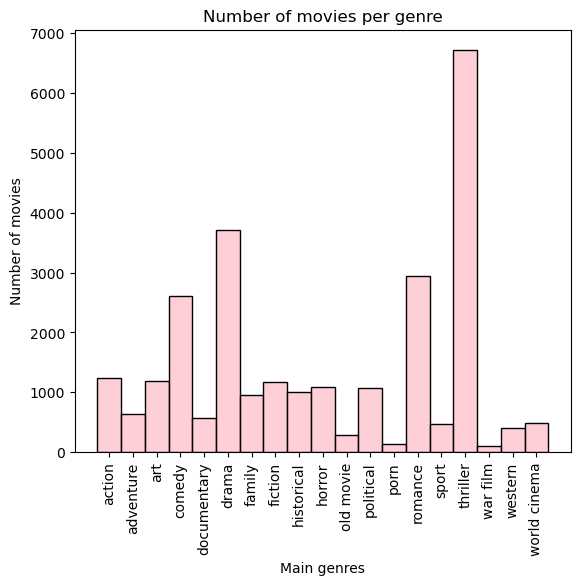

In [14]:
movie_metadata_filtered['Movie_main_genre'] = movie_metadata_filtered.Movie_main_genre.astype('category')

ax = sns.histplot(movie_metadata_filtered,x='Movie_main_genre',stat='count',color='pink')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.gcf().subplots_adjust(bottom=0)
ax.set(xlabel="Main genres",ylabel="Number of movies",title="Number of movies per genre")

 We can see that most of the movies fall in the 'Thriller', 'Drama', 'Romance' and 'Comedy' categories. 

We won't be using the 'Movie_genres', 'Movie_languages', and 'Movie_main_language' for further analyses, we thus drop these columns.

In [15]:
movie_metadata_filtered.drop(labels=["Movie_genres","Movie_languages","Movie_main_language"],axis=1,inplace=True)

## 1.4 - Character metadata processing

We want to merge the character dataset and the movie dataset on the "Wikipedia_movie_ID". It will be useful to investigate the relationship between the characters and the title of the movie (Batman in Batman movies for example). We thus compute a column with a list of characters for each movie.

In [16]:
#Drop row without character names
movie_characters = movie_metadata_filtered.copy(deep=True)

character_metadata_copy = character_metadata.copy(deep=True)
character_metadata_copy.dropna(subset=['Character_name'], inplace=True)

character_metadata_copy.drop(labels=["Movie_release_date","Freebase_movie_ID"],axis=1,inplace=True)

movie_characters=movie_characters.merge(character_metadata_copy, how='inner',left_on='Wikipedia_movie_ID', right_on='Wikipedia_movie_ID')

movie_characters = movie_characters[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_box_office_revenue', 'Movie_runtime', 'Movie_countries', 'Movie_main_genre', 'Character_name', 'Freebase_character_ID']]


movie_characters = movie_characters.groupby('Wikipedia_movie_ID').agg({
    'Movie_name': 'first',  
    'Movie_box_office_revenue': 'first', 
    'Movie_runtime': 'first',  
    'Movie_countries': 'first',  
    'Movie_main_genre': 'first',  
    'Character_name': lambda x: list(x),  
    'Freebase_character_ID':  lambda x: list(x)
}).reset_index()
movie_characters.sample(5).head()

,Wikipedia_movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Freebase_character_ID
14388,25011263,The Hook,NaN,98.0,[United States of America],drama,[P.J. Briscoe],[/m/0h2wr69]
6936,5469422,The Poof Point,NaN,90.0,[United States of America],fiction,[Eddie Ballard],[/m/0h2th69]
15616,29730492,Wuthering Heights,NaN,123.0,[United Kingdom],romance,"[Mrs Linton, Heathcliff, Heathcliff, Mr Earnsh...","[/m/0h0j6hj, /m/02pyc3p, /m/02pyc3p, /m/0h0j8h..."
14354,24870003,Cracks,NaN,104.0,"[Spain, Ireland, United Kingdom]",political,"[Laurel, Miss G, Di, Fiamma, Poppy, Lily, Rosi...","[/m/0bgjpl2, /m/0bgjpf6, /m/0bgjpds, /m/0bgjpd..."
11469,15530875,Big Time,NaN,87.0,[United States of America],drama,"[Eddie Burns, Lily Clark, Gloria, Sybil, Eli]","[/m/0jvlwm9, /m/0jvlwmx, /m/0jvlwmm, /m/0jvlwn..."


What is the proportion of movies with a title that contain one of the character's name?

In [17]:
# Check if one of the character's name is present in the movie title
def is_in_title(df):
    characters = df['Character_name']
    title = str(df['Movie_name'])
    for i in characters:
        if str(i) in title:
            return True
        return False

movie_characters['Protagonist_in_title'] = movie_characters.apply(lambda x: is_in_title(x), axis=1)
movie_with_protagonist_in_title = movie_characters['Protagonist_in_title'].sum()

print(f"Fraction of movie titles containing character name: {movie_with_protagonist_in_title / len(movie_characters):.2%}")
print(movie_characters.loc[movie_characters['Protagonist_in_title'] == 1, ['Movie_name', 'Character_name']])

Fraction of movie titles containing character name: 2.94%
                               Movie_name  \
3                                  Batman   
6                          Batman Forever   
43                         The Terminator   
52                               THX 1138   
81                 The Life of Emile Zola   
...                                   ...   
16270           The Elizabeth Smart Story   
16380               Margaret Bourke-White   
16410  Captain America II: Death Too Soon   
16430                      Up Goes Maisie   
16463     Rita Hayworth: The Love Goddess   

                                          Character_name  
3      [Batman, Catwoman, Joker, Penguin, Riddler, Al...  
6      [Batman, Harvey Dent, Dr. Chase Meridian, Suga...  
43     [Terminator, Kyle Reese, Sarah Connor, Punk Le...  
52     [THX, SEN, SRT, LUH, PTO, TWA, NCH, DWY, IMM, ...  
81                                          [Emile Zola]  
...                                            

Does this parameter have an impact on the success? 

*Naive analysis, to be continued...*

We now merge our filtered movie dataset with the movie_character data created on the "Wikipedia_movie_ID" column. We only keep "Character_name", "Character in title" and "Wikipedia_movie_ID" on the movie_character dataset.

In [18]:
movie_characters.drop(labels=["Movie_name","Movie_box_office_revenue","Movie_runtime","Movie_countries","Movie_main_genre","Freebase_character_ID"],axis=1,inplace=True)

movie_metadata_filtered = movie_metadata_filtered.merge(movie_characters,how='left', on = 'Wikipedia_movie_ID')
movie_metadata_filtered.to_csv("Data/movies_preprocessed.csv")

**We now have a clean dataset that contains only the information we need for our further analysis.**

# 2 - First visualizations: insights on the evolution of title features over time

To determine whether or not the movie release year is an important confounder, we performed a time series analysis on selected features. Indeed, if title features vary a lot over time, we should divide our dataset according to adequate movie periods and take the movie release date into account when designing the prediction model, having it as input along with the movie title.

The datasets used for time series analysis are the results of the preprocessing and of the sentiment and part-of-speech analyses. As we have created several notebooks to work in parallel, they are imported. The sentiment and part-of-speech analyses are performed in part 4, and here we just use the result dataset containing the columns of interest. This allows a more logical progression through our project and avoid runtime errors.

Here is the distribution of movies per year of our pre-processed dataset. It is very similar to the one displayed in 1.2 before filtering, but it is useful to have it in mind for the time series analysis.

[Text(0.5, 1.0, 'Number of movies per year'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Number of movies')]

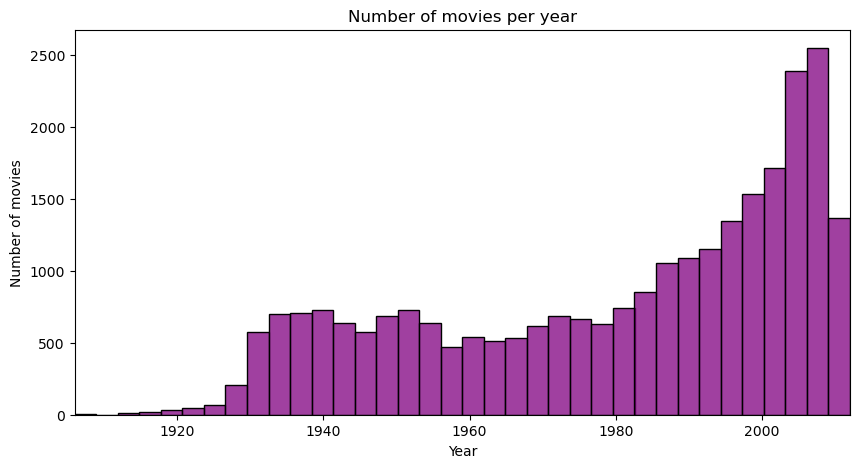

In [4]:
# Open pre-processed CMU dataset
movies = pd.read_csv('Data/movies_preprocessed.csv')

# Plot the distribution of the number of movies in the dataset over time
plt.figure(figsize=(10,5))
plt.xlim(1906,2012)
sns.histplot(movies,x='Movie_release_date',stat='count',color="purple").set(title="Number of movies per year",xlabel="Year",ylabel="Number of movies")

## 2.1 - Title length in words and characters

Its length is the most obvious feature of a title. It can be characterized by the number of words or of characters. We analyze here the evolution of these two features over time for all movie genre and for each movie genre.

In [11]:
# Helper functions to count the words and characters in movie titles
def count_words(x):
    # remove eventual spaces at the beginning and at the end of the string, split the string, count the words
    return len(x.strip().split())

def count_characters(input_string):
    return len(input_string)

movies['Title_length_words'] = movies['Movie_name'].apply(count_words)
movies['Title_length_characters'] = movies['Movie_name'].apply(count_characters)

In [14]:
# Group by genres to get an interactive plot of the evolution of title length in words
genres_length_words = movies.groupby(['Movie_main_genre', 'Movie_release_date'], as_index=False)['Title_length_words'].agg(['mean', 'sem', 'count']).reset_index()
# Group only by movie release date to get the average title length across all genres per year
all_length_words = movies.groupby(by='Movie_release_date')['Title_length_words'].agg( ['count','mean','sem'] ).reset_index()


# Plot of the average title length per year per genre 
fig = px.line(genres_length_words, x='Movie_release_date', y='mean', error_y='sem', color='Movie_main_genre',
              hover_data={'Movie_release_date': True, 'mean': True, 'sem': False, 'count': True}, 
              # display when the mouse is on datapoint the mean title length, its standard error mean and the number of movies that year
              labels={'mean': 'Mean title length (words)', 'Movie_release_date': 'Release year', 
                      'sem':'Standard error mean', 
                      'count':'Number of movies',
                      'Movie_main_genre': 'Main genre'},
              title='Evolution of average title length in words for each movie genre and for all movie genres').update_traces(error_y_color='#d3d3d3')


# Update layout to include legend with clickable items
fig.update_layout(legend=dict(traceorder='normal'))

# Update traces to make legend items clickable
for genre in genres_length_words['Movie_main_genre'].unique():
    fig.update_traces(visible='legendonly', selector=dict(name=genre))

# Add a trace with the average values per year across all genre and display only it initially
additional_trace = px.line(all_length_words, x='Movie_release_date', y='mean', error_y='sem', 
                hover_data={'Movie_release_date': True, 'mean': True, 'sem': False, 'count': True},
                labels={'mean': 'Mean title length (words)', 'count':'Number of movies',
                        'Movie_release_date': 'Release year'},
                title='Average title length in words per year').update_traces(name='all genres', 
                                                                              line_color='#808080', 
                                                                              error_y_color='#d3d3d3',
                                                                              showlegend=True)

fig.add_trace(additional_trace.data[0])

* The title length in words across all genres is scattered in the early 20th century. This is due to the fact that our dataset contains very few movies released between 1906 and 1928 (less than a hundred). Therefore, we will focus on movies released after 1928 for the rest of the time series analysis.

* The average title length in words across all genres is **fairly stable from 1928 to 2012** (very narrow confidence intervals): it remains around 3 words.  

Our dataset contains very different number of movies per genre per year. Curves are less significant in genres where there are few movies per year.

* For movie genres with few movies per year in our dataset, such as `Documentary` or `Sport` (most years with fewer than 10 movies), the title length in words varies greatly from one year to the other and we cannot identify a general trend. This does not mean that the release year influence the title length in words for these genres, there is simply to few data to extract trends and as the average title length across all genres do not evolve over time we can hypothesize that it is the case for each genre.

* For movie genres with more movies per year in our dataset, we can draw some conclusions. `Romance`, `Comedy` and `Drama` have rather equal mean length in words and the same variations over time. Their mean length varies little around 3 words over time. `Horror`movies have an average length of 3 words over time (analysis after 1970).

**Conclusion:** The release year do not influence the mean title length in words and we do not need to take into account that parameter for the prediction model.

In [13]:
# Group by genres to get an interactive plot of the evolution of title length in characters
genres_length_characters = movies.groupby(['Movie_main_genre', 'Movie_release_date'], as_index=False)['Title_length_characters'].agg(['mean', 'sem', 'count']).reset_index()
# Group only by movie release date to get the average title length across all genres per year
all_length_characters = movies.groupby(by='Movie_release_date')['Title_length_characters'].agg( ['count','mean','sem'] ).reset_index()


# Plot of the average title length per year per genre 
fig = px.line(genres_length_characters, x='Movie_release_date', y='mean', error_y='sem', color='Movie_main_genre',
              hover_data={'Movie_release_date': True, 'mean': True, 'sem': False, 'count': True}, 
              # display when the mouse is on datapoint the mean title length, its standard error mean and the number of movies that year
              labels={'mean': 'Mean title length (characters)', 'Movie_release_date': 'Release year', 
                      'sem':'Standard error mean', 
                      'count':'Number of movies',
                      'Movie_main_genre': 'Main genre'},
              title='Evolution of average title length in characters for each movie genre and for all movie genres').update_traces(error_y_color='#d3d3d3')


# Update layout to include legend with clickable items
fig.update_layout(legend=dict(traceorder='normal'))

# Update traces to make legend items clickable
for genre in genres_length_characters['Movie_main_genre'].unique():
    fig.update_traces(visible='legendonly', selector=dict(name=genre))

# Add a trace with the average values per year across all genre and display only it initially
additional_trace = px.line(all_length_characters, x='Movie_release_date', y='mean', error_y='sem', 
                hover_data={'Movie_release_date': True, 'mean': True, 'sem': False, 'count': True},
                labels={'mean': 'Mean title length (words)', 'count':'Number of movies',
                        'Movie_release_date': 'Release year'},
                title='Average title length in words per year').update_traces(name='all genres', 
                                                                              line_color='#808080', 
                                                                              error_y_color='#d3d3d3',
                                                                              showlegend=True)

fig.add_trace(additional_trace.data[0])

* The title length in characters across all genres is scattered in the early 20th century. This is due to the fact that our dataset contains very few movies released between 1906 and 1928 (less than a hundred). Therefore, we will focus on movies released after 1928 for the rest of the time series analysis.

* The average title length in characters across all genres is also  **fairly stable from 1928 to 2012** (very narrow confidence intervals): it remains around 17 characters.  

* For movie genres with more movies per year in our dataset, we can draw some conclusions. `Romance`, `Comedy` and `Drama` have again rather equal mean length in characters and the same variations over time. Their mean length varies little around 16 words over time. According to a [Trinity College study](http://www.cs.trincoll.edu/~crypto/resources/LetFreq.html), the average length of English words is 4.5 letters. It gives on average 3.5 words: the obtained numbers of characters and of words are therefore coherent.

**Conclusion:** The release year do not influence the mean title length in characters and we do not need to take into account that parameter for the prediction model.

## 2.2 - Sentiment analysis

The sentiment analysis of a movie title, whether positive, negative, or neutral, often aligns with the thematic tone of the film within its respective genre. We explore how positive and negative sentiment tones in title evolved over time.

In [6]:
# Open dataset with sentiment analysis and part-of-speech analysis features
features = pd.read_csv('Data/key_features.csv')

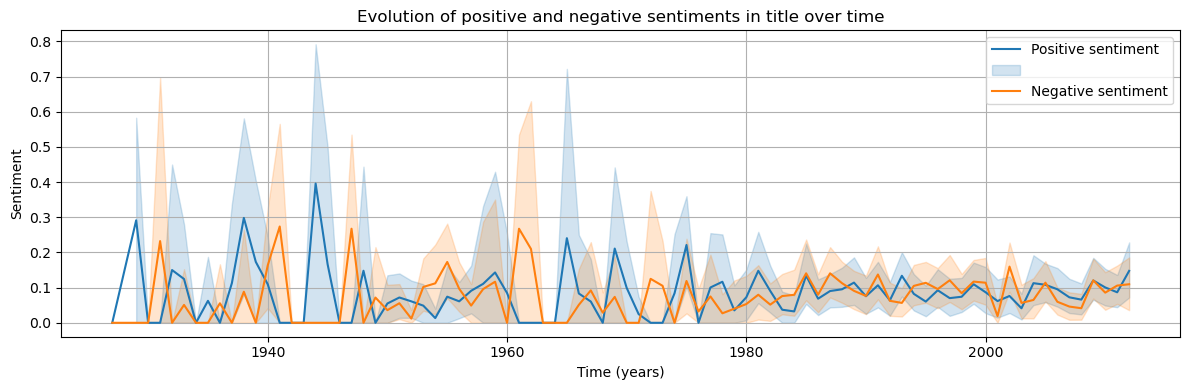

In [12]:
# Plot the evolution of positive and negative sentiments over time with eroor bars
plt.figure(figsize=(12,4))
plt.xlabel('Time (years)')
plt.ylabel('Sentiment')
plt.grid()
plt.title('Evolution of positive and negative sentiments in title over time')
sns.lineplot(x='Movie_release_date', y='pos_sentiment', errorbar='ci', data=features)
sns.lineplot(x='Movie_release_date', y='neg_sentiment', errorbar='ci', data=features)
plt.legend(['Positive sentiment', '', 'Negative sentiment'])
plt.tight_layout()

* Movie titles convey on average the same positive and negative sentiments. The curves are intertwined throughout the time period.

* Confidence intervals vary considerably from 1906 until 1980, which may be due to the fact that our dataset contains fewer movies for that time period. From 1980 until 2012, the time period for which our dataset contains most movies, the confidence intervals are smaller and the mean value more stable.

* Mean values for positive and negative sentiment conveyed by title after 1980 remain between 0.0 and 0.2 over time. 

**Conclusion:** As the release year has little influence on the sentiment conveyed by movie titles, we do not need to take into account that parameter for the prediction model.

## 2.3 - Part-of-speech analysis (proper nouns)

The presence of a protagonist name or of a specific place in a movie title could influence its success. We analyze the evolution of the presence of proper nouns over time (part-of-speech analysis).

As described in the 4.4 part, only the `PERSON` and `ORGANIZATION` types of proper nouns are well represented. Therefore we will only keep those ones to look at their presence in titles over time.

In [7]:
# Add a column indicating if there is no organization or person proper noun in title (0, 1 if there is at least one of them)
features['PERS_ORG'] = ( features['PERSON'] | features['ORGANIZATION']).astype(bool)

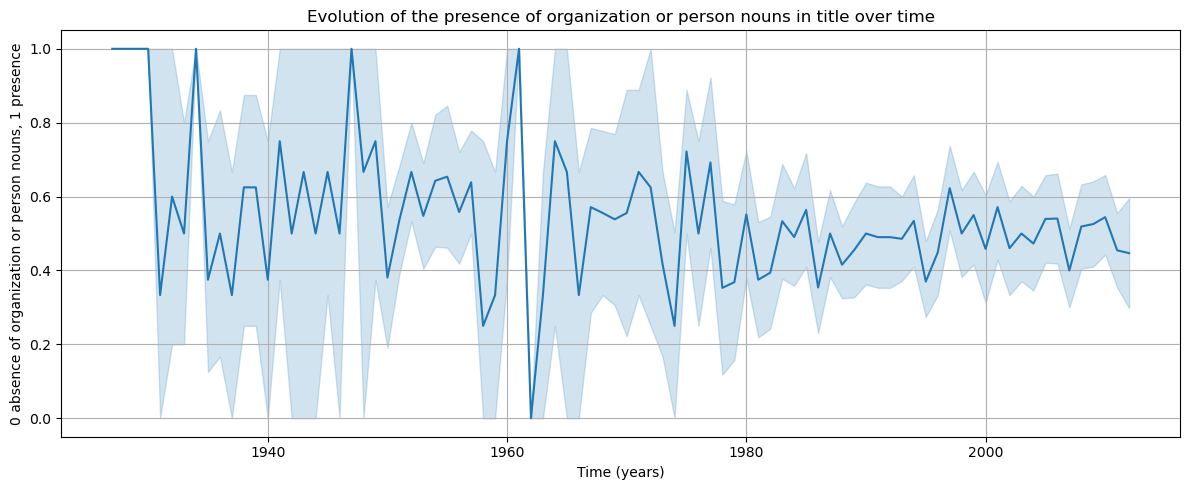

In [13]:
# Plot the evolution of the presence of proper nouns in title
plt.figure(figsize=(12,5))
plt.xlabel('Time (years)')
plt.ylabel('0 absence of organization or person nouns, 1 presence')
plt.grid()
plt.title('Evolution of the presence of organization or person nouns in title over time')
sns.lineplot(x='Movie_release_date', y='PERS_ORG', errorbar='ci', data=features)
plt.tight_layout()

* From 1980, around 50% of the movie titles include an organization or a person proper noun, the values range between 40% and 60%. 

* Confidence intervals vary considerably from 1906 until 1980, which may be due to the fact that our dataset contains fewer movies for that time period. From 1980 until 2012, the time period for which our dataset contains most movies, the confidence intervals are smaller and the mean value more stable.

**Conclusion:** As the proportion of movie titles including a person or organization proper nouns is not linked to the release year for most movies, we do not need to take into account that parameter for the prediction model.

## Conclusion

The selected title features (length, sentiment conveyed, presence of proper nouns) evolve little over time: the release year of the movie does not need to be an input or a parameter of the prediction model.

# 3 - Analysis of success confounders

The IMdB movies dataset imported from IMdB website is huge (882.4 Mo) and therefore long to process. As it contains many unuseful features and many unuseful movies (i.e. not present in the CMU pre-processed dataset), we will reduce its size and combine it to the IMdB ratings dataset (23.7 Mo) and then merge the obtained dataset to the pre-processed CMU dataset. In the end, we will get a pre-processed CMU-IMdB dataset that is simpler and faster to use.

**The pre-processing is described in the notebook 'Dataset-preprocessing-IMdB-Rotten-tomatoes'.**

## 3.1 - Financial data pre-processing

We are interested in conducting an analysis to explore the relationship between the title of a movie and its success. While the title seems to be a crucial aspect since it is a the first hook, it is undoubtable that other factors, such as the cast, director, and movie studio, may exert a more significant influence on a film's success. To gain a comprehensive understanding of the impact of the title, it is essential to **analyze potential confounding variables affecting success**. 
 
 In this context, success is measured by both the **movie revenue** (box office earnings minus budget) and the **ratings** from IMDb. To do so, an indicator of success is calculated.

Any data including budget and revenues has to be adjusted with inflation rates. To do this, Consumer Price Indexes were found on OECD statistics, for the years comprised between 1913 and 2012.

We chose to consider the cmu_imdb dataset because the movies_ratings dataset (with IMdB + Rottent tomatoes ratings) provides fewer data.

In [26]:
# Load the pre-processed CMU-IMdB dataset and drop rows with a NaN box office revenue
movies_cmu_imdb = pd.read_csv('Data/cmu_imdb.csv')
print('Size of the dataset with all box office revenues : ', movies_cmu_imdb.shape)

movies_cmu_imdb.dropna(subset=['Movie_box_office_revenue'], inplace=True)
print('Size of the dataset without null box office revenues : ', movies_cmu_imdb.shape)
movies_cmu_imdb.head(2)

Size of the dataset with all box office revenues :  (13825, 15)
Size of the dataset without null box office revenues :  (3142, 15)


,Unnamed: 0.1,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Character_in_title,Audience_imdb_rating,Audience_imdb_count,Title_length
0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,"['Akooshay', 'Lieutenant Melanie Ballard', 'De...",False,4.9,56887,3
1,1,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,['Roger Grant AKA Alexander'],False,6.8,2268,3


Droping the rows without Box office revenue truly decreases the dataset size. This will have to be taken in account for further studies.

Now we have to adjust the box office revenue with the inflation rate, which we can due thanks to the consumer price index (CPI), using 2012 as a year of reference.

In [27]:
# Load the dataframe with Consumer Price indexes (CPI)
# The year of reference is 2012 (latest movie release year)
# Adjust each movie box office with the consumer price index corresponding to the year of release 

cpi = pd.read_csv('Data/CPI.csv', sep=';')
cpi['Annual'] = cpi['Annual'].str.replace(',', '.')
cpi['Annual'] = pd.to_numeric(cpi['Annual'], errors='coerce')

cpi_value_2012 = cpi.loc[cpi['Year'] == 2012, 'Annual'].values[0] # take 2012 as the reference year for the cpi 

def adjust_inflation_box_office(row):
    year = row['Movie_release_date']
    consumer_price_index = cpi['Annual'][cpi['Year'] == year].values[0]
    revenue_adjusted = row['Movie_box_office_revenue'] * (cpi_value_2012 / consumer_price_index)
    return revenue_adjusted

# Adjust the box office with the inflation by adding a new column Box_office_adjusted
movies_cmu_imdb['Box_office_adjusted'] = movies_cmu_imdb.apply(adjust_inflation_box_office, axis=1)
movies_cmu_imdb.head(2)


,Unnamed: 0.1,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Character_in_title,Audience_imdb_rating,Audience_imdb_count,Title_length,Box_office_adjusted
0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,"['Akooshay', 'Lieutenant Melanie Ballard', 'De...",False,4.9,56887,3,1.816424e+07
1,1,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,['Roger Grant AKA Alexander'],False,6.8,2268,3,5.862128e+07


Complementary data about movies was found on https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/.
We indeed need more information on production companies and movie budget for the success analysis. 
Information about movie directors was also found on IMdB.
All those additional data is comprised in the dataset movies_additional_info. The budget also has to be adjusted because of the inflation.

In [28]:
movies_additional_info = pd.read_csv('Data/movies_additional_info.csv')
movies_additional_info.shape

(41293, 6)

In [29]:
# Keep only movies budgets for years comprised between 1913 and 2012 (because of the inflation CPI dataset) 

movies_additional_info = movies_additional_info[(movies_additional_info['ReleaseYear'] >= 1913) & (movies_additional_info['ReleaseYear'] < 2013)]
movies_additional_info['ReleaseYear'] = movies_additional_info['ReleaseYear'].astype('int64')

# Adjust movies budgets with inflation with each consumer price index of the year of release 

def adjust_inflation_budget(row):
    year = row['ReleaseYear']
    consumer_price_index = cpi['Annual'][cpi['Year'] == year].values[0]
    revenue_adjusted = row['Budget'] * (cpi_value_2012 / consumer_price_index)
    return revenue_adjusted

movies_additional_info['Budget_adjusted'] = movies_additional_info.apply(adjust_inflation_budget, axis=1)

movies_additional_info.shape

(34035, 7)

The additional information about movies dataset is merged with clean the dataset we used previously, movies_cmu_imdb.

In [30]:
# Merge movies_budget_ratings with movies_cmu_imdb on Movie Name and Movie Release Date

success_data = movies_cmu_imdb.merge(movies_additional_info, left_on=['Movie_name', 'Movie_release_date'], right_on=['Title', 'ReleaseYear'], how='inner')
print('Size of the dataset with IMdB ratings and budget : ',success_data.shape)

Size of the dataset with IMdB ratings and budget :  (2655, 23)


We first thought to compile the profit (revenue-budget). Let's see if we have enough data:

In [31]:
#Number of movies without budget data
success_data[success_data['Budget_adjusted']==0].shape

(1310, 23)

This reduce our dataframe a lot. We thus decide to work only with the revenue (?)

In [32]:
# To remove?
# Adding the movie profit column, with Profit = Box office revenue - Budget 

success_data['Profit'] = success_data['Box_office_adjusted'] - success_data['Budget_adjusted']
Unuseful = ['Title', 'ReleaseYear']
success_data.drop(Unuseful, axis=1, inplace=True)
success_data.head(2)

,Unnamed: 0.1,Unnamed: 0_x,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,...,Audience_imdb_rating,Audience_imdb_count,Title_length,Box_office_adjusted,Unnamed: 0_y,Budget,Production Companies,Director,Budget_adjusted,Profit
0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,...,4.9,56887,3,1.816424e+07,4330,28000000,"['Screen Gems', 'Storm King Productions', 'Ani...",John Carpenter,3.630040e+07,-1.813615e+07
1,1,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,...,6.8,2268,3,5.862128e+07,7660,2000000,['Twentieth Century Fox Film Corporation'],Henry King,3.256738e+07,2.605390e+07


In [33]:
# Normalise the movies profits and the ratings to have homogenised and comparatible success indicators

success_data['Movie_box_office_revenue'].dropna(inplace = True)
print('Size of the dataset with the budget and ratings : ', success_data.shape)

success_data['Profit_standardized']= ((success_data['Profit']-success_data['Profit'].mean())/ success_data['Profit'].std())
success_data['imdb_rating_standardized']= (success_data['Audience_imdb_rating']-success_data['Audience_imdb_rating'].mean())/ success_data['Audience_imdb_rating'].std()
success_data['Revenue_standardized']= (success_data['Movie_box_office_revenue']-success_data['Movie_box_office_revenue'].mean())/ success_data['Movie_box_office_revenue'].std()

# Create an indicator for success, based on ratings and box office revenues
success_data["Success_indicator"]= (success_data['imdb_rating_standardized'] + success_data['Revenue_standardized'])/2
success_data.head(2)


Size of the dataset with the budget and ratings :  (2655, 22)


,Unnamed: 0.1,Unnamed: 0_x,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,...,Unnamed: 0_y,Budget,Production Companies,Director,Budget_adjusted,Profit,Profit_standardized,imdb_rating_standardized,Revenu_standardized,Success_indicator
0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,...,4330,28000000,"['Screen Gems', 'Storm King Productions', 'Ani...",John Carpenter,3.630040e+07,-1.813615e+07,-0.604779,-1.455197,-0.324095,-0.889646
1,1,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,...,7660,2000000,['Twentieth Century Fox Film Corporation'],Henry King,3.256738e+07,2.605390e+07,-0.208255,0.544569,-0.448579,0.047995


[Text(0.5, 0, 'Success indicator'),
 Text(0, 0.5, 'Number of movies'),
 Text(0.5, 1.0, 'Distribution of our success indicator among movies of the dataset')]

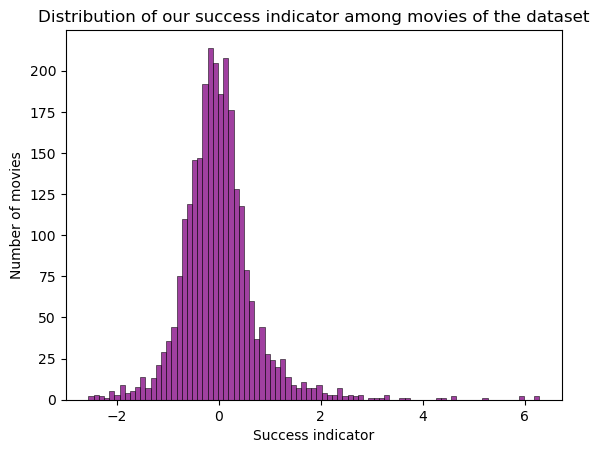

In [34]:
ax=sns.histplot(data=success_data,x='Success_indicator',color="purple")
ax.set(xlabel='Success indicator',ylabel='Number of movies',title='Distribution of our success indicator among movies of the dataset')

## 3.2 - Famous actors

We would like to know if the presence of famous actors influence the movie success. To do so, we use a list of the 100 most famous actors (taken from IMdB) to discriminate famous and not famous actors.

In [35]:
# load the dataset with the list of famous actors (top 100 from IMdB) and filter only the useful columns 

famous_actors= pd.read_csv('Data/famous_actors.csv')

top100actors=famous_actors.head(100)
unuseful = ['Description', 'Birth Date', 'Created', 'Modified', 'Known For', 'Position']
top100actors.drop(unuseful, axis =1, inplace=True)
top100actors.head(2)

,Const,Name
0,nm0000134,Robert De Niro
1,nm0000197,Jack Nicholson


In [36]:
# Merge movies and character metadata to have access to actors information for each movie, on Wipikedia_movie_ID
success_data=success_data.merge(character_metadata[['Wikipedia_movie_ID','Actor_name','Freebase_character_ID']], on='Wikipedia_movie_ID', how='inner')

In [37]:
# Group movies and actors dataframe by movie and aggregate actors and characters
success_data = success_data.groupby('Wikipedia_movie_ID').agg({
    'Freebase_movie_ID': 'first', 'Movie_name': 'first',
    'Movie_release_date': 'first', 'Movie_box_office_revenue': 'first', 'Movie_runtime': 'first',
    'Movie_countries': 'first', 'Movie_main_genre':'first', 'Box_office_adjusted':'first','Director':'first',
    'Audience_imdb_rating': 'first', 'Audience_imdb_count': 'first', 'Budget': 'first', 'Protagonist_in_title':'first',
    'Profit': 'first', 'Budget_adjusted': 'first', 'Production Companies':'first','Revenue_standardized':'first',
    'Profit_standardized': 'first', 'imdb_rating_standardized': 'first', 'Success_indicator': 'first',
    'Actor_name': lambda x: ','.join(x.dropna()),
    'Freebase_character_ID': lambda x: ', '.join(x.dropna())
}).reset_index()
print('Size of the dataset with the actors: ', success_data.shape)


Size of the dataset with the actors:  (2630, 23)


In [38]:
#We  change the type of object of the actors name (from str to list of str)

success_data['Actor_name']=success_data['Actor_name'].apply(lambda x: x.split(sep=','))


In [39]:
# To be considered as famous, an actor has to be in the famous_actors dataset
# We create a column to indicate for each movie how many famous actors he has.

Famous_Actors=[]
for i in success_data.index:
    A=0
    for actor in success_data['Actor_name'][i]:
        if actor in list(top100actors['Name']):
            A+=1
    Famous_Actors.append(A)


success_data['Famous_actors_count']=Famous_Actors


/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/1430237009.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=success_data, x='Famous_actors_count',y='Success_indicator',palette='colorblind')


[Text(0.5, 0, 'Number of famous actors'),
 Text(0, 0.5, 'Success indicator'),
 Text(0.5, 1.0, 'Average success of movies depending of the number of famous actors')]

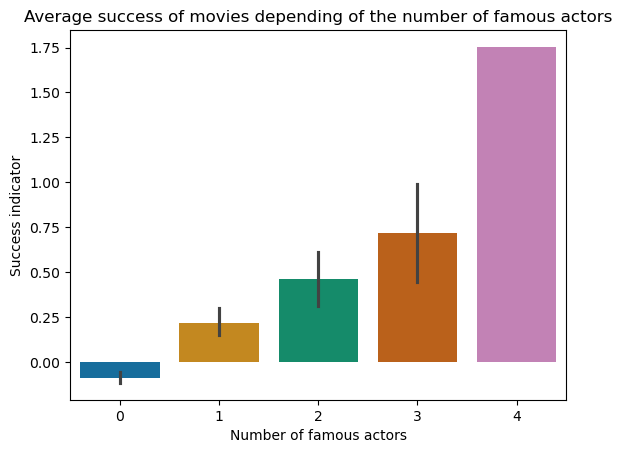

In [40]:
# Create a bar plot to visualize the relationship between the presence of famous actors  and the success indicator of movies

ax = sns.barplot(data=success_data, x='Famous_actors_count',y='Success_indicator',palette='colorblind')
ax.set(xlabel='Number of famous actors',ylabel='Success indicator',title='Average success of movies depending of the number of famous actors')

Here we are studying the influence of the cast on a movie's success, specifically exploring whether the number of renowned actors correlates with heightened success in a film. Our findings suggest a positive association between the presence of famous actors and increased movie success. This observation is interesting as renowned actors may serve as confounding variables, potentially impacting the relationship between our movie title and its success.

To confirm our hypothesis, let's perform statistical test. Here, we want to know if  the success indicator mean of one of at least the groups (no famous actor, 1 famous actor, 2 famous actors, 3 famous actor or 4 famous actors) is different.
To do so, we perform a ANOVA 1 test or its non-parametrical equivalent, a Kruskal-Wallis test.

Only one movie has 4 famous actors, we thus decide to remove this group from our anaylysis to be able to perform the statistical test.

In [66]:
# Drop row with 4 famous actor for analysis
Famous_actor_influence=success_data.copy(deep=True)
Famous_actor_influence=Famous_actor_influence[Famous_actor_influence['Famous_actors_count'] != 4]

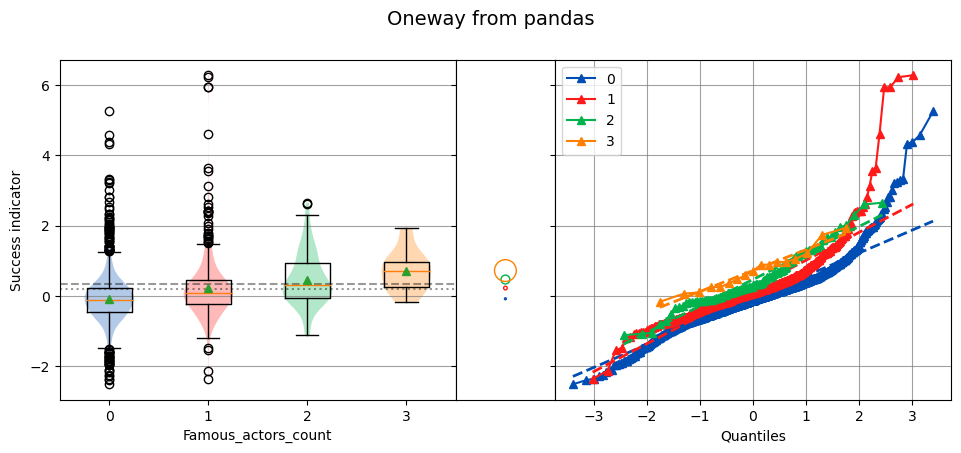



Overall Statistics
------------------

Number of Groups =  4
Total            =  2629
Grand Mean       =  0.3293
Pooled Std Dev   =  0.7323
Grand Median     =  0.1976


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
1975          -0.0856        0.6810       -2.5227       -0.1141        5.2549       0             
544            0.2204        0.8936       -2.3667        0.0921        6.2895       1             
93             0.4634        0.7623       -1.1219        0.3031        2.6540       2             
17             0.7191        0.5759       -0.1699        0.6992        1.9365       3             


Levene Test
-----------

alpha   =  0.0500
W value =  3.4351
p value =  0.0163

HA: Variances are not equal



Kruskal-Wallis
--------------

alpha   =  0.0500
h value =  128.9765
p value =  0.0000


In [67]:
# Perform the statistical test: the function analyze chooses automatically the parametric or 
#non-parametric test depending on the normality of the residual and the homoscedasticity of the data
analyze(
    Famous_actor_influence['Success_indicator'],
    groups=Famous_actor_influence['Famous_actors_count'],
    categories='Famous_actors_count',
    name='Success indicator',
    title='Oneway from pandas'
)

print()

The p-value of the Kruskal-Wallis test is inferiror 0.05. We can reject the negative hypothesis H0 (all means are the same). The success indicator means of movies is thus different for the number of famous actors in the movie.

To conclude, it will be important to consider this confounding factor for future studies. Our upcoming investigations will extend beyond to explore additional factors, including the movie production studio, the director influence, and the budget.

## TO REFORMULATE?

## 3.3 - Famous production studios   

We would like to know whether the fact that a movie was producted by a famous studio influences the success of a movie. The influence of a famous studio on the success of a movie is a multifaceted topic that involves various aspects of the film industry : brand recognition, financial backing, marketing, promotion, distribution and industrial networks...

A list of famous movie studios was found on  (https://en.wikipedia.org/wiki/Major_film_studios#:~:text=Today%2C%20the%20Big%20Five%20majors,to%20afford%20to%20watch%20films) : 
NBCUniversal, Paramount Pictures Corporation, Warner Bros Entertainment, Walt Disney Studios, Sony Pictures, RKO Pictures, United Artists, Metro-Goldwyn-Mayer, 20th Century Fox. Those studios are indeed considered as the best studios today and also as the best ones over the last century. 

In [42]:
#top_studios = ['NBCUniversal', 'Paramount Pictures Corporation', 'Warner Bros Entertainment', 'Walt Disney Productions', 'Sony Pictures', 'RKO Pictures', 'United Artists', 'Metro-Goldwyn-Mayer', 'Twentieth Century Fox Film Corporation']
top_studios_keywords = ['NBC', 'Universal', 'Paramount', 'Warner', 'Disney', 'Sony', 'RKO', 'United Artists', 'Goldwyn', 'Century Fox']

In [43]:
# Analyse if movies were produced by a famous studio
# A studio is famous if its name is related to the top studios 
success_data['IsFamousStudio']= success_data['Production Companies'].apply(lambda x: any(keyword in x for keyword in top_studios_keywords))
success_data.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Box_office_adjusted,Director,...,Budget_adjusted,Production Companies,Revenu_standardized,Profit_standardized,imdb_rating_standardized,Success_indicator,Actor_name,Freebase_character_ID,Famous_actors_count,IsFamousStudio
0,3217,/m/014hr,Army of Darkness,1992,21502796.0,81.0,['United States of America'],horror,3.518918e+07,Sam Raimi,...,1.800143e+07,"['Universal Pictures', 'Renaissance Pictures',...",-0.234513,-0.287812,1.176074,0.470781,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...","/m/0hgcnkq, /m/089hc6, /m/06_krl, /m/0jtgxg3, ...",0,True
1,3947,/m/0191n,Blue Velvet,1986,8551228.0,120.0,['United States of America'],thriller,1.791389e+07,David Lynch,...,1.256934e+07,['De Laurentiis Entertainment Group (DEG)'],-0.389376,-0.394083,1.491826,0.551225,"[Dick Green, Isabella Rossellini, Kyle MacLach...","/m/0hgw_bt, /m/0gz5lsj, /m/0h39qn5, /m/0hgw_dk...",0,False
2,4231,/m/01cbx,Buffy the Vampire Slayer,1992,16624456.0,86.0,['United States of America'],action,2.720581e+07,Fran Rubel Kuzui,...,1.145545e+07,"['Twentieth Century Fox Film Corporation', 'Ku...",-0.292844,-0.300710,-0.613190,-0.453017,"[Kristy Swanson, Donald Sutherland, Paul Reube...","/m/0b41h, /m/0h5s5mz, /m/0h5s5p6, /m/0h2n0pr, ...",0,True
3,4728,/m/01hq1,Batman Returns,1992,266822354.0,126.0,"['United States of America', 'United Kingdom']",thriller,4.366530e+08,Tim Burton,...,1.309195e+08,"['PolyGram Filmed Entertainment', 'Warner Bros.']",2.698799,2.301351,0.860321,1.779560,"[Cristi Conaway, Michael Gough, Pat Hingle, Ja...","/m/0h5rr59, /m/02r129, /m/031v20, /m/0h5rr4q, ...",1,True
4,5224,/m/01lsl,Citizen Kane,1941,1585634.0,119.0,['United States of America'],thriller,2.476609e+07,Orson Welles,...,1.311574e+07,"['RKO Radio Pictures', 'Mercury Productions']",-0.472665,-0.337500,2.123331,0.825333,"[Dorothy Comingore, Erskine Sanford, Everett S...","/m/04vwr27, /m/04vwr0s, /m/04vwr2j, /m/04vwq_x...",0,True


/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/1874491527.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=success_data, x='IsFamousStudio',y='Success_indicator',palette='colorblind')
/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/1874491527.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['Non famous studio','Famous studio'],xlabel=None, ylabel='Success indicator',title='Average success of movies depending of the fame of the studio')


[[Text(0, 0, 'Non famous studio'), Text(1, 0, 'Famous studio')],
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Success indicator'),
 Text(0.5, 1.0, 'Average success of movies depending of the fame of the studio')]

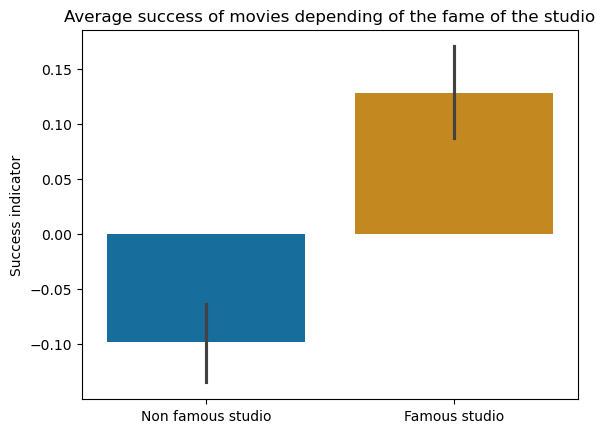

In [44]:
# Create a bar plot to visualize the relationship between the fame of the studio (IsFamousStudio=1) and the success indicator of movies

success_data['IsFamousStudio'] = success_data['IsFamousStudio'].astype(int)
ax = sns.barplot(data=success_data, x='IsFamousStudio',y='Success_indicator',palette='colorblind')
ax.set(xticklabels=['Non famous studio','Famous studio'],xlabel=None, ylabel='Success indicator',title='Average success of movies depending of the fame of the studio')

The means of success indicator for the 2 groups seems different. Let's perfom a T-test to confirm this hypothetis

In [70]:
# T-test
cat1 = success_data[success_data['IsFamousStudio']==0]
cat2 = success_data[success_data['IsFamousStudio']==1]

ttest_ind(cat1['Success_indicator'],cat2['Success_indicator'])

TtestResult(statistic=-7.771743602725118, pvalue=1.1019508649349882e-14, df=2628.0)

The p-value of the t-test is inferior to 0.05. We can thus reject H0 (means of the two groups are the same). We can thus conclude that the fame of the studio has an impact on the success. If the studio is one of the most famous studio, it is more likely to have a high success indicator.

Again, this conclusion is important for our future study on success related to title, because the production studio is a confounder for success.

## 3.4 - Famous directors

Exploring the impact of renowned film directors on movie success : this analysis aims to uncover insights into how distinguished directors contribute to the success of the films they helm. 
We select a list of the top 50 influential directors (found on https://thecinemaarchives.com/2020/08/17/the-250-best-directors-of-all-time/) and analyse the influence on the success of the movies helmed by those directors. 

In [46]:
famous_directors = pd.read_csv('Data/FilmDirectors.csv')
famous_directors.rename(columns={'Directors;': 'Directors'}, inplace =True)
famous_directors['Directors'] = famous_directors['Directors'].str.extract(r'\d+\.\s(.+);')
top50directors = famous_directors.head(50)
top50directors.head(3)

,Directors
0,Alfred Hitchcock
1,Stanley Kubrick
2,Ingmar Bergman


In [47]:
success_data['IsFamousDirector']= success_data['Director'].isin(top50directors['Directors'])

/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/1590611859.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=success_data, x='IsFamousDirector',y='Success_indicator',palette='colorblind')
/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/1590611859.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['Non famous directors','Famous directors'],xlabel=None,ylabel='Success indicator',title='Average success of movies depending of the fame of the director')


[[Text(0, 0, 'Non famous directors'), Text(1, 0, 'Famous directors')],
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Success indicator'),
 Text(0.5, 1.0, 'Average success of movies depending of the fame of the director')]

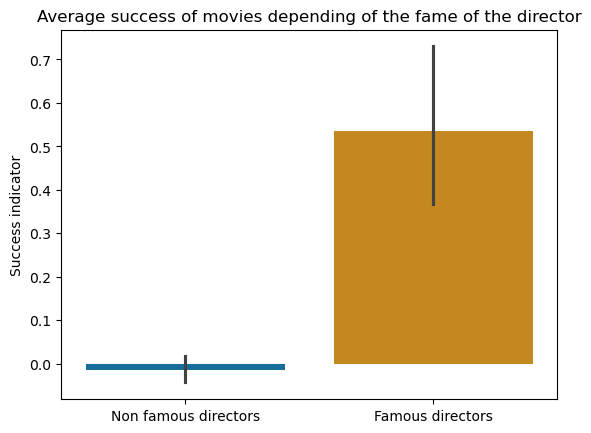

In [48]:
# Create a bar plot to visualize the relationship between the fame of the director (IsFamousDirector==1) and the success indicator of movies

success_data['IsFamousDirector'] = success_data['IsFamousDirector'].astype(int)
ax = sns.barplot(data=success_data, x='IsFamousDirector',y='Success_indicator',palette='colorblind')
ax.set(xticklabels=['Non famous directors','Famous directors'],xlabel=None,ylabel='Success indicator',title='Average success of movies depending of the fame of the director')

Again, the difference of success indicator mean between movies produce by a famous director and other movies seems obvious. We perform a t-test to confirm this.

In [49]:
#T-test
cat3 = success_data[success_data['IsFamousDirector']==0]
cat4 = success_data[success_data['IsFamousDirector']==1]

ttest_ind(cat3['Success_indicator'],cat4['Success_indicator'])

TtestResult(statistic=-6.855485250183014, pvalue=8.824410120295185e-12, df=2628.0)

The p-value is indeed inferior to 0.05. The fame of the director is then another confoundder for a movie success.

## 3.5 - Budget

Because the data on movies' budget was reducing too much our dataframe, we decided not to include it in the success indicator (and using the profit instead of the revenu). However, it could be intersting to look into the influence of the budget on movies' success.

In [50]:
# Create standardized budget and create csv for website
success_data['Budget_standardized']= (success_data['Budget_adjusted']-success_data['Budget_adjusted'].mean())/ success_data['Budget_adjusted'].std()
success_data.to_csv("Data/success_data.csv")

In [51]:
# Remove rows with budget of 0 (missing information)
indexNames=success_data[success_data['Budget_adjusted']==0].index
budget_analysis_data=success_data.drop(indexNames)

[Text(0.5, 0, 'Standardized budget'),
 Text(0, 0.5, 'Number of movies'),
 Text(0.5, 1.0, 'Distributon of movies budget')]

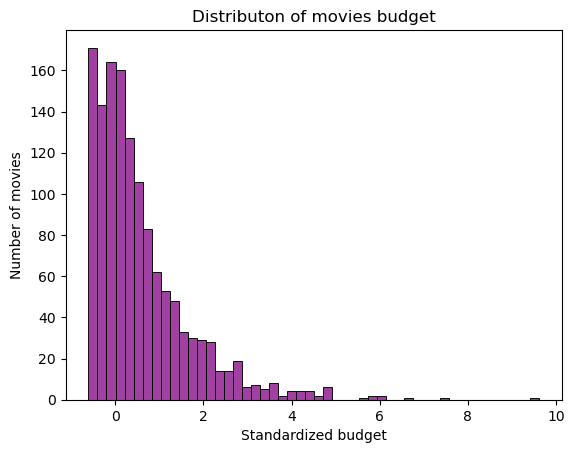

In [52]:
# Plot distribution of the budget
ax=sns.histplot(data=budget_analysis_data,x='Budget_standardized',color='purple')
ax.set(xlabel='Standardized budget',ylabel='Number of movies',title='Distributon of movies budget')


## heavy tailed distribution and log scale?? not sure
The budget of our movieset has a heavy-tailed distribution. We thus go to logscale to represent our data.

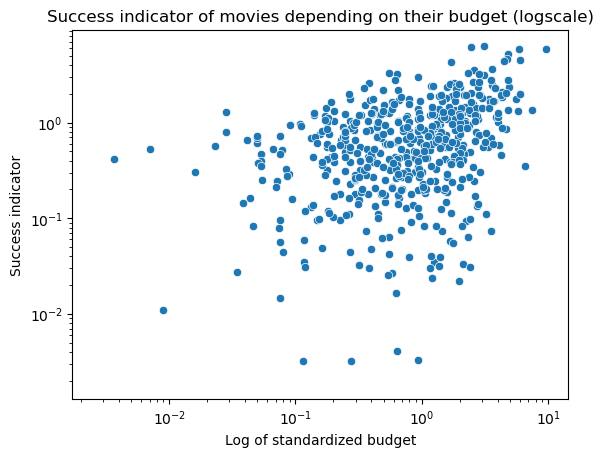

In [72]:
#Plot
ax=sns.scatterplot(data=budget_analysis_data,x='Budget_standardized',y='Success_indicator')
ax.set(xlabel='Log of standardized budget', ylabel='Success indicator', title='Success indicator of movies depending on their budget (logscale)')
plt.xscale('log')
plt.yscale('log')


## Correlation with logregression?? pb, our data are negative, not working

In [54]:
mod_2=smf.ols(formula='imdb_rating_standardized ~ Budget_standardized ', data=success_data)

res_2 = mod_2.fit()

print(res_2.summary())

                               OLS Regression Results                               
Dep. Variable:     imdb_rating_standardized   R-squared:                       0.000
Model:                                  OLS   Adj. R-squared:                 -0.000
Method:                       Least Squares   F-statistic:                    0.2684
Date:                      Fri, 15 Dec 2023   Prob (F-statistic):              0.604
Time:                              12:24:58   Log-Likelihood:                -3691.2
No. Observations:                      2630   AIC:                             7386.
Df Residuals:                          2628   BIC:                             7398.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

There is no correlation between the budget and the success indicator, meaning that we could exclude it from our potential confounders.

## 3.6 - Movie genre

The genre of the movie might influences its success. Let's plot the average success per genre.

/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_99147/638967518.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=success_data, x='Movie_main_genre',y='Success_indicator',palette='colorblind')


[Text(0.5, 0, 'Main movie genres'),
 Text(0, 0.5, 'Success indicator'),
 Text(0.5, 1.0, 'Average success indicator of main movie genres')]

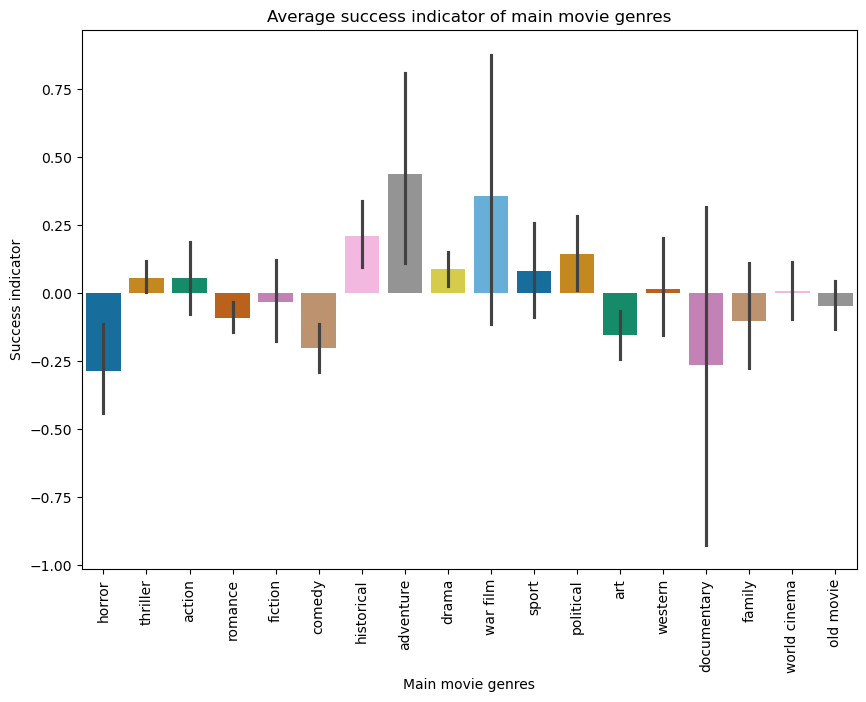

In [55]:
plt.figure(figsize=(10,7))
plt.xticks(rotation=90)
ax = sns.barplot(data=success_data, x='Movie_main_genre',y='Success_indicator',palette='colorblind')
ax.set(xlabel='Main movie genres',ylabel='Success indicator',title='Average success indicator of main movie genres')


It seems like the success indicator's mean is changing depending on the genre of the movies. Let's perfom an ANOVA statistical test (parametric or non-parametric alternative).

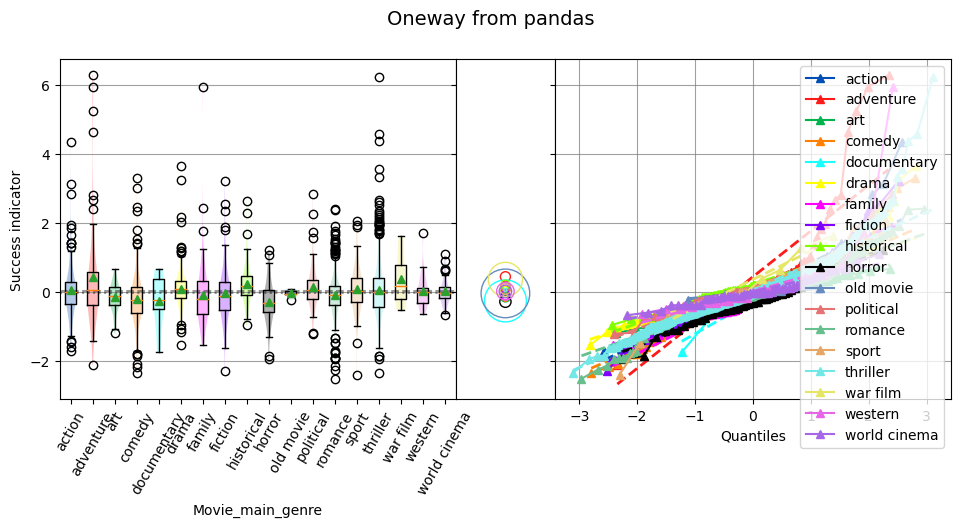



Overall Statistics
------------------

Number of Groups =  18
Total            =  2630
Grand Mean       =  0.0145
Pooled Std Dev   =  0.7403
Grand Median     = -0.0301


Group Statistics
----------------

n             Mean          Std Dev       Min           Median        Max           Group         
--------------------------------------------------------------------------------------------------
137            0.0565        0.8362       -1.7094       -0.0187        4.3415       action        
72             0.4359        1.5155       -2.1217        0.0405        6.2895       adventure     
78            -0.1551        0.3907       -1.2093       -0.1269        0.6589       art           
266           -0.2040        0.7405       -2.3667       -0.2332        3.2950       comedy        
6             -0.2659        0.8759       -1.7601       -0.2283        0.6714       documentary   
288            0.0882        0.5531       -1.5511        0.0938        3.6571       drama         
8

In [73]:
# Perform statistical analysis, ANOVA or non-parametric ANOVA (Kruslkall Wallis)
analyze(
    success_data['Success_indicator'],
    groups=success_data['Movie_main_genre'],
    categories='Movie_main_genre',
    name='Success indicator',
    title='Oneway from pandas'
)

The p-value is inferior to 0.05, and we can thus reject the null Hypothesis. The means of success indicator for different genres are not matched. The genre of the movie is another confounder for the success of a movie.

### Conclusion

These insights on potential confoudners for success of a movie reveal that a lot of factors can influence our success indicator. We thought about creating a matching dataset, but these kind of "tricks" only works for binary data (one control group and one treated group). Binarize our success indicator would be risky to provide meaningful conclusions for further analysis. Thus, we have to remain careful when analyzing further results, and keep in mind these confounders.

# 4 - Analysis of the influence of title key features on success

In [72]:
# import all necessary librairies


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english")) # we focus on english titles only
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
lemmatizer= WordNetLemmatizer()
from collections import Counter
from nltk.tokenize import RegexpTokenizer
stop_words = set(stopwords.words("english")) # we focus on english titles only
import string
punctuation = set(string.punctuation)



[nltk_data] Downloading package punkt to /Users/Clarisse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [49]:
# import the data

movies=pd.read_csv('Data/success_data.csv')
movies.head(3)

,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Box_office_adjusted,...,Revenu_standardized,Profit_standardized,imdb_rating_standardized,Success_indicator,Actor_name,Freebase_character_ID,Famous_actors_count,IsFamousStudio,IsFamousDirector,Budget_standardized
0,0,3217,/m/014hr,Army of Darkness,1992,21502796.0,81.0,['United States of America'],horror,3.518918e+07,...,-0.234513,-0.287812,1.176074,0.470781,"['Ted Raimi', 'Ivan Raimi', 'Bruce Campbell', ...","/m/0hgcnkq, /m/089hc6, /m/06_krl, /m/0jtgxg3, ...",0,1,0,-0.052560
1,1,3947,/m/0191n,Blue Velvet,1986,8551228.0,120.0,['United States of America'],thriller,1.791389e+07,...,-0.389376,-0.394083,1.491826,0.551225,"['Dick Green', 'Isabella Rossellini', 'Kyle Ma...","/m/0hgw_bt, /m/0gz5lsj, /m/0h39qn5, /m/0hgw_dk...",0,0,1,-0.219767
2,2,4231,/m/01cbx,Buffy the Vampire Slayer,1992,16624456.0,86.0,['United States of America'],action,2.720581e+07,...,-0.292844,-0.300710,-0.613190,-0.453017,"['Kristy Swanson', 'Donald Sutherland', 'Paul ...","/m/0b41h, /m/0h5s5mz, /m/0h5s5p6, /m/0h2n0pr, ...",0,1,0,-0.254054


## 4.1 - Title length in words and characters

In [25]:
# Helper function to count the words in movie titles
def count_words(x):
    # remove eventual spaces at the beginning and at the end of the string, split the string, count the words
    return len(x.strip().split())

In [26]:
# Add column with title length
movies['Title_length'] = movies['Movie_name'].apply(count_words)


/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

Text(0.5, 0.98, 'Join distributions of Success & title length')

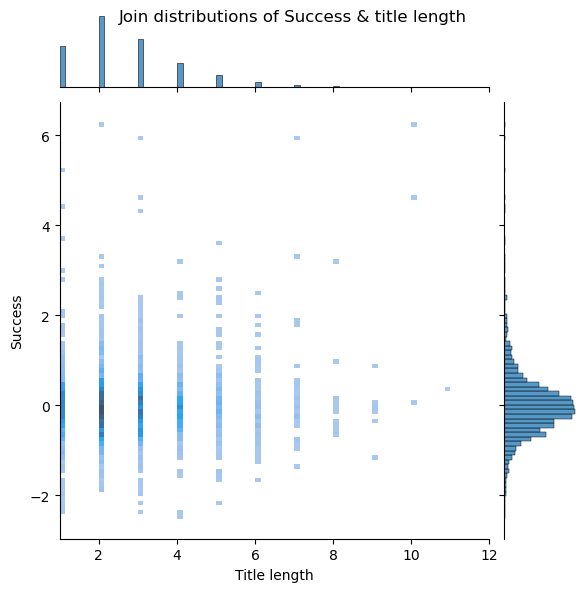

In [27]:
# Plot the join distributions of audience IMdB rating & title length
# As there are more short titles, looking only at the mean rating for each title length is biased

jplot = sns.jointplot(x='Title_length', y='Success_indicator', data=movies, kind='hist', xlim=(1,12))
#jplot = sns.jointplot(x='Title_length', y='Audience_imdb_rating', data=cmu_imdb, kind='hist', xlim=(1,12))

plt.xlabel('Title length')
plt.ylabel('Success') 
jplot.fig.suptitle('Join distributions of Success & title length')

As there are more short titles (one or two words), looking only at the mean rating for each title length is biased. Consequently, we rather look at the distribution of the number of characters.


/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

Text(0.5, 0.98, 'Join distributions of Success & number of characters in title')

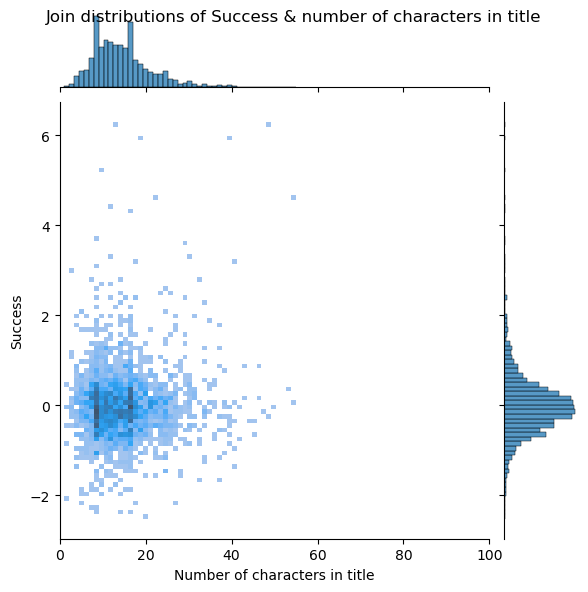

In [28]:
# Add column with number of characters 
movies['Title_characters'] = movies['Movie_name'].apply(len)

# Plot the join distributions of success indicator & number of characters in the title

jplot = sns.jointplot(x='Title_characters', y='Success_indicator', data=movies, kind='hist',xlim=(0,100))

plt.xlabel('Number of characters in title')
plt.ylabel('Success') 
jplot.fig.suptitle('Join distributions of Success & number of characters in title')

For both the number of words and the number of characters, we obtain a heavy tailed distribution. The number of characters allow us to have a better resolution than the number of words. The plot doesn't show a correlation between the number of characters in the title and the success.

## 4.2 - Presence of protagonist

We can also look at whether the presence of the character's name in the title influences the movie success since it is preatty speaking for the viewer.

In [29]:
movies.Character_in_title

0       False
1       False
2       False
3       False
4       False
        ...  
2625    False
2626      NaN
2627    False
2628    False
2629    False
Name: Character_in_title, Length: 2630, dtype: object

/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='Character_in_title', ylabel='Success_indicator'>

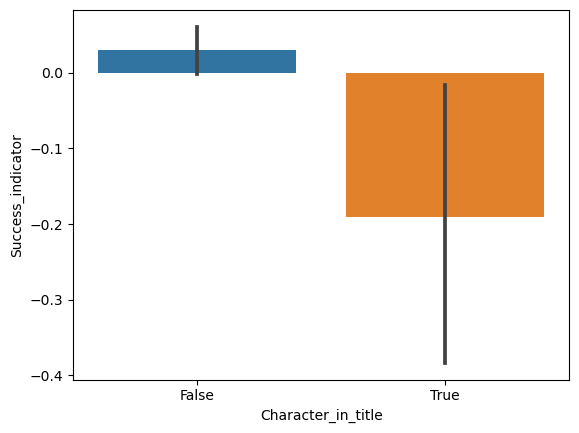

In [30]:
sns.barplot(data=movies,x='Character_in_title',y='Success_indicator')

Based on this plot, the presence of the protagonist name in the title is associated with a lower success.

## 4.3 - Part-of-speech Tagging : grammatical structure

Now let's consider the grammatical construction of titles. First, we use Part-of-speech tagging to uncover the potential influence of certain parts of speech such as verbs, adjectives, nouns...

In [31]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english")) # we focus on english titles only
from nltk.tokenize import sent_tokenize, word_tokenize

In [32]:
# create the dataframe of Tags
tag = {'Nouns': [], 'Pronouns': [],'Adjectives':[],
          'Verbs':[],'Adverbs':[],'Prepositions':[],
          'Conjunctions':[],'Interjections':[]}

tag_df=pd.DataFrame(data=tag)

tag_df.head()

,Nouns,Pronouns,Adjectives,Verbs,Adverbs,Prepositions,Conjunctions,Interjections


In [33]:
# fills the Tags dataframe by going through all movie titles

for i in range (0,len(movies)):

    Tags=[0,0,0,0,0,0,0,0]

    # load title
    title=movies['Movie_name'].iloc[i]
    
    # cut into individual words
    title_list=word_tokenize(title)
    
    # tagging parts of speech
    post_tags=nltk.pos_tag(title_list)
    
    Types=[]
    for word, pos_tag in post_tags:
        Types.append(pos_tag)
    

    for type in Types:
        if type.startswith('NN'):
            Tags[0]+=1
        elif type.startswith('PRP'):
            Tags[1]+=1
        elif type.startswith('JJ'):
            Tags[2]+=1
        elif type.startswith('VB'):
            Tags[3]+=1
        elif type.startswith('RB'):
            Tags[4]+=1
        elif type.startswith('IN'):
            Tags[5]+=1
        elif type.startswith('CC'):
            Tags[6]+=1
        elif type.startswith('UH'):
            Tags[7]+=1

    tag_df.loc[i]=Tags

In [34]:
# add the Tags columns to the dataframe
movies = pd.concat([movies, tag_df], axis=1)
movies.head(3)

,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Box_office_adjusted,...,Title_length,Title_characters,Nouns,Pronouns,Adjectives,Verbs,Adverbs,Prepositions,Conjunctions,Interjections
0,0,3217,/m/014hr,Army of Darkness,1992,21502796.0,81.0,['United States of America'],horror,3.518918e+07,...,3,16,2,0,0,0,0,1,0,0
1,1,3947,/m/0191n,Blue Velvet,1986,8551228.0,120.0,['United States of America'],thriller,1.791389e+07,...,2,11,2,0,0,0,0,0,0,0
2,2,4231,/m/01cbx,Buffy the Vampire Slayer,1992,16624456.0,86.0,['United States of America'],action,2.720581e+07,...,4,24,2,0,0,0,0,1,0,0


In [35]:
titles_nouns=pd.concat([movies[movies.Nouns!=0]['Success_indicator'],pd.Series(['nouns' for i in range(0,len(movies[movies.Nouns!=0]))])],axis=1)
titles_pronouns=pd.concat([movies[movies.Pronouns!=0]['Success_indicator'],pd.Series(['pronouns' for i in range(0,len(movies[movies.Pronouns!=0]))])],axis=1)
titles_adjectives=pd.concat([movies[movies.Adjectives!=0]['Success_indicator'],pd.Series(['adjectives' for i in range(0,len(movies[movies.Adjectives!=0]))])],axis=1)
titles_verbs=pd.concat([movies[movies.Verbs!=0]['Success_indicator'],pd.Series(['verbs' for i in range(0,len(movies[movies.Verbs!=0]))])],axis=1)
titles_adverbs=pd.concat([movies[movies.Adverbs!=0]['Success_indicator'],pd.Series(['adverbs' for i in range(0,len(movies[movies.Adverbs!=0]))])],axis=1)
titles_prepositions=pd.concat([movies[movies.Prepositions!=0]['Success_indicator'],pd.Series(['prepositions' for i in range(0,len(movies[movies.Prepositions!=0]))])],axis=1)
titles_conjunctions=pd.concat([movies[movies.Conjunctions!=0]['Success_indicator'],pd.Series(['conjunctions' for i in range(0,len(movies[movies.Conjunctions!=0]))])],axis=1)
titles_interjections=pd.concat([movies[movies.Interjections!=0]['Success_indicator'],pd.Series(['interjections' for i in range(0,len(movies[movies.Interjections!=0]))])],axis=1)



In [36]:
data_Tags=pd.concat([titles_nouns,titles_pronouns,titles_adjectives,titles_verbs,titles_adverbs,
                    titles_prepositions,titles_conjunctions,titles_interjections],axis=0)
data_Tags.tail()
data_Tags=data_Tags.rename(columns={"Success_indicator": "Success_indicator", 0: "Tag"})


/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/

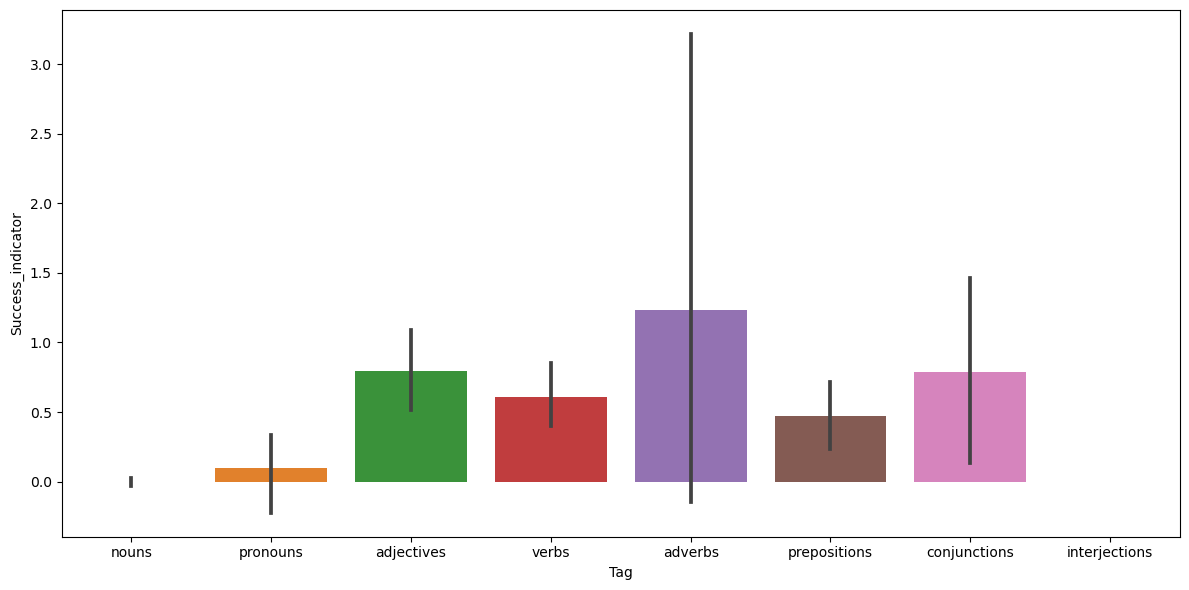

In [97]:
plt.figure(figsize=(12,6))
sns.barplot(x='Tag',y='Success_indicator',data=data_Tags)

plt.tight_layout()

There is a strong success indicator for films containing adjectives, adverbs and conjunctions. However, films with nouns seem to have a null success indicator which seems strange. It would be interesting to 1) look at the success indicator values for nouns and 2) to look at the number of films in each categories to see if comparing the error bars is relevant or not.

2623 total values and 
2349 non NaN values


Text(0, 0.5, 'Counts')

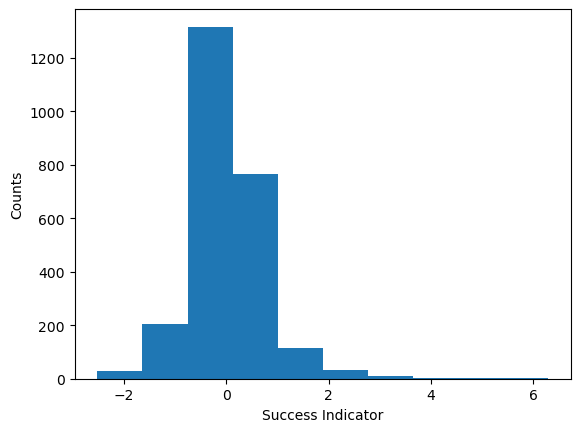

In [39]:
print(len(titles_nouns), 'total values and ')
print(len(titles_nouns.dropna()), 'non NaN values')
plt.hist(titles_nouns.Success_indicator)
plt.xlabel('Success Indicator')
plt.ylabel('Counts')

So it's not an artefact of the data, nouns in the title do not influence the success of the movie.

Additionally, we wonder if the adverbs and conjunctions are really associated with a higher success or whether there is a biais of the number of adverbs and conjunctions detected (see the size of the errorbars).

In [98]:
print('Nouns:',len(titles_nouns),'Pronouns:',len(titles_pronouns),'Adjectives:',len(titles_adjectives),'Verbs:',len(titles_verbs),'Adverbs:',len(titles_adverbs),'Prepositions:',len(titles_prepositions),'Conjunctions:',len(titles_conjunctions),'Interjections:',len(titles_interjections))

Nouns: 2623 Pronouns: 239 Adjectives: 525 Verbs: 632 Adverbs: 187 Prepositions: 834 Conjunctions: 217 Interjections: 4


Adverbs and conjunctions have less datapoints, which explains the high variablility between the datapoints, hence the large standart deviation. Due to the very small number of interjection detected (4), we can decide to dismiss this parameter.

Conclusion: Titles with adjectives, adverbs and conjunctions are associated with a higher success indicator, whereas nouns are associated with a null success indicator (having nouns has no influence on the success).

## 4.4 - Named Entities Recognition : characters, dates, location...

Now we use Named Entity Recognition to unravel the influence of having Person, Location of Date objects in the title on success.

In [50]:
# create the Dataframe of NER

ner = {'ORGANIZATION': [], 'PERSON': [],'LOCATION':[],
          'DATE':[],'TIME':[],'MONEY':[], 'PERCENT':[],
          'FACILITY':[],'GPE':[]}


ner_df=pd.DataFrame(data=ner)

ner_df.head()

,ORGANIZATION,PERSON,LOCATION,DATE,TIME,MONEY,PERCENT,FACILITY,GPE


In [51]:
for i in range (0,len(movies)):
    
    NER=[0,0,0,0,0,0,0,0,0]

    # load title
    title=movies['Movie_name'].iloc[i]
    
    # cut into individual words
    title_list=word_tokenize(title)
    
    # tagging NER
    ne_tree = nltk.ne_chunk(nltk.pos_tag(title_list))

    # Access named entities and their labels

    ne_label=[]
    for subtree in ne_tree:
        if isinstance(subtree, nltk.Tree):  # Check if the subtree is a named entity
            #print('coucou')
            ne_label.append(subtree.label())
            
    for type in ne_label:
        if type=='ORGANIZATION':
            NER[0]+=1
        elif type=='PERSON':
            NER[1]+=1
        elif type=='LOCATION':
            NER[2]+=1
        elif type=='DATE':
            NER[3]+=1
        elif type=='TIME':
            NER[4]+=1
        elif type=='MONEY':
            NER[5]+=1
        elif type=='PERCENT':
            NER[6]+=1
        elif type=='FACILITY':
            NER[7]+=1
        elif type=='GPE':
            NER[8]+=1
        #else:
            #print("caramba!")

    ner_df.loc[i]=NER
    


In [52]:
movies = pd.concat([movies, ner_df], axis=1)
movies.head(3)

,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Box_office_adjusted,...,Budget_standardized,ORGANIZATION,PERSON,LOCATION,DATE,TIME,MONEY,PERCENT,FACILITY,GPE
0,0,3217,/m/014hr,Army of Darkness,1992,21502796.0,81.0,['United States of America'],horror,3.518918e+07,...,-0.052560,2,0,0,0,0,0,0,0,0
1,1,3947,/m/0191n,Blue Velvet,1986,8551228.0,120.0,['United States of America'],thriller,1.791389e+07,...,-0.219767,1,1,0,0,0,0,0,0,0
2,2,4231,/m/01cbx,Buffy the Vampire Slayer,1992,16624456.0,86.0,['United States of America'],action,2.720581e+07,...,-0.254054,1,0,0,0,0,0,0,0,0


In [99]:
# graph

titles_person=movies[movies.PERSON!=0]
titles_organization=movies[movies.ORGANIZATION!=0]
titles_location=movies[movies.LOCATION!=0]
titles_date=movies[movies.DATE!=0]
titles_time=movies[movies.TIME!=0]
titles_money=movies[movies.MONEY!=0]
titles_percent=movies[movies.PERCENT!=0]
titles_facility=movies[movies.FACILITY!=0]
titles_gpe=movies[movies.GPE!=0]


print('PERSON:',len(titles_person),'ORGANIZATION:',len(titles_organization),'LOCATION:',len(titles_location),'DATE:',len(titles_date),'TIME:',len(titles_time))


PERSON: 704 ORGANIZATION: 877 LOCATION: 6 DATE: 0 TIME: 0


Since only the PERSON and ORGANIZATION types are well represented, we will only keep those ones to look at the success.

In [54]:
titles_rest=movies[movies.PERSON==0][movies.ORGANIZATION==0]
len(titles_rest)

/var/folders/g3/cmtrqyyx2g31_0nljjqrcp800000gn/T/ipykernel_89023/2666447765.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  titles_rest=movies[movies.PERSON==0][movies.ORGANIZATION==0]


1306

/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<AxesSubplot:xlabel='PERSON', ylabel='Success_indicator'>

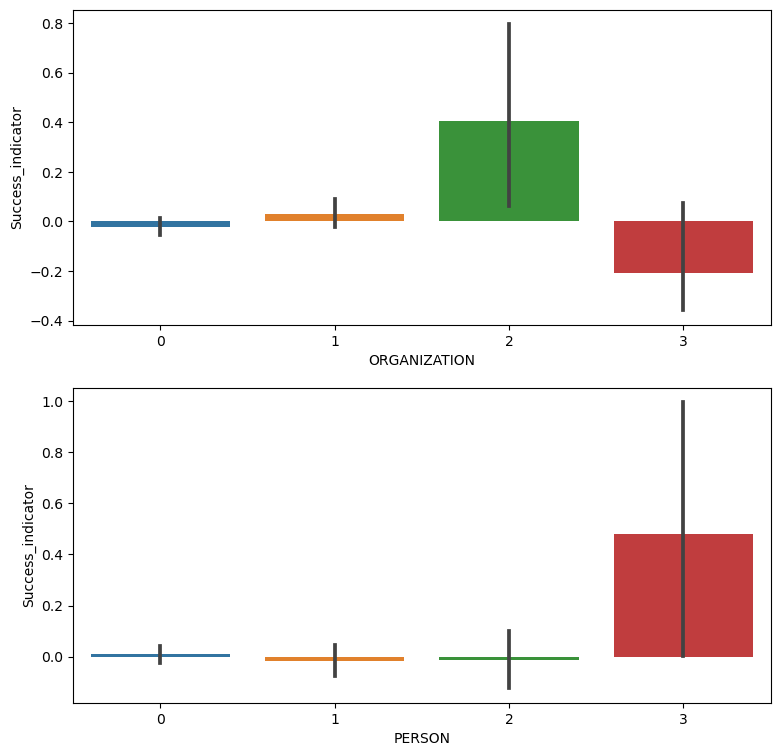

In [56]:
fig,(ax1,ax2)=plt.subplots(2,figsize=(9,9))

sns.barplot(data=movies,x='ORGANIZATION',y='Success_indicator',ax=ax1)
sns.barplot(data=movies,x='PERSON',y='Success_indicator',ax=ax2)

We see that the number of ORGANIZATION and PERSON items influence the success indicator.
ORGANIZATION: the success is maximum for 2 Organization occurences and minimum for 3.
PERSON: the success is maximum for 3 Person occurences and zero for 0 to 2 occurences.

Instead of looking at the number of occurences of person or organization type, we can decide to compare movie titles with at least one person or one organization type. If the title contains both types, it will be considered in both categories.

In [57]:
titles_ORG=pd.concat([titles_organization['Success_indicator'],pd.Series(['ORGANIZATION' for i in range(0,len(titles_organization))])],axis=1)
titles_PER=pd.concat([titles_person['Success_indicator'],pd.Series(['PERSON' for i in range(0,len(titles_person))])],axis=1)
titles_REST=pd.concat([titles_person['Success_indicator'],pd.Series(['-' for i in range(0,len(titles_rest))])],axis=1)

data_NER=pd.concat([titles_ORG,titles_PER,titles_REST],axis=0)
data_NER=data_NER.rename(columns={"Success_indicator": "Success_indicator", 0: "NER"})



/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


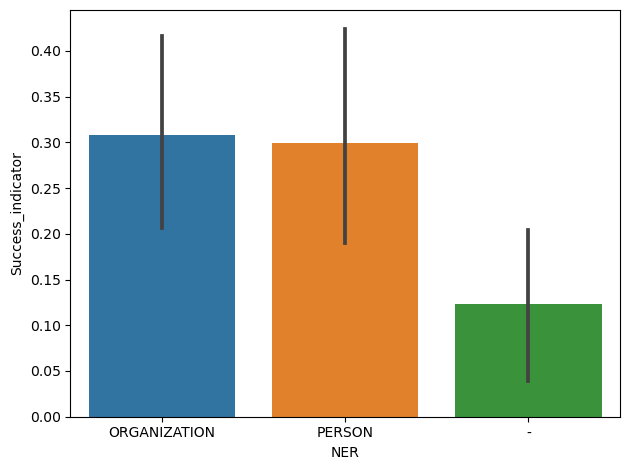

In [58]:
sns.barplot(x='NER',y='Success_indicator',data=data_NER)

plt.tight_layout()

According to this plot, having a named organization or person in the movie title influences the success of the movie (almost x3). We don't see much difference between the organization and the person type. However, we must nuance those results by taking into account the previous plots, the difference with titles that contain no ORGANIZATION or PERSON item might be significant because of the few titles that contain more than 1 occurence.

## 4.5 - Sentiment analysis

We want to investigate the lexical fields and the conotation of our titles. This would provide us useful information to link with success, time, genre. We make the naive assumption that darker, scarier movies are associated with negative sentiments, whereas comedy and romance films are associated with more positive sentiments.


NLTK is a well-known and well-trained NLP library. The NLTK.ipynb notebook goes through basic functions of NLTK package that could be applied to movie's title.

#### NLTK's Sentiment Analyzer (pre-trained)

NLTK already has a built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner).

Since VADER is pretrained, you can get results more quickly than with many other analyzers. However, VADER is best suited for language used in social media, like short sentences with some slang and abbreviations. It’s less accurate when rating longer, structured sentences. This point is actually very interesting for us since titles are usually short.



In [60]:
#An example of polarity sentiment analysis with NLTK

sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Wow, NLTK is really powerful!")

{'neg': 0.0, 'neu': 0.295, 'pos': 0.705, 'compound': 0.8012}

In [62]:
# Sentiment analysis depending on genre

sia = SentimentIntensityAnalyzer()
L_pos=[]
L_neg=[]


for i in range(len(movies)):
    movie_name = movies.iloc[i].Movie_name
    scores = sia.polarity_scores(movie_name)
    L_pos.append(scores["pos"])
    L_neg.append(scores["neg"])


movies['pos_sentiment']=L_pos
movies['neg_sentiment']=L_neg

movies.head(3)

,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Box_office_adjusted,...,PERSON,LOCATION,DATE,TIME,MONEY,PERCENT,FACILITY,GPE,pos_sentiment,neg_sentiment
0,0,3217,/m/014hr,Army of Darkness,1992,21502796.0,81.0,['United States of America'],horror,3.518918e+07,...,0,0,0,0,0,0,0,0,0.0,0.5
1,1,3947,/m/0191n,Blue Velvet,1986,8551228.0,120.0,['United States of America'],thriller,1.791389e+07,...,1,0,0,0,0,0,0,0,0.0,0.0
2,2,4231,/m/01cbx,Buffy the Vampire Slayer,1992,16624456.0,86.0,['United States of America'],action,2.720581e+07,...,0,0,0,0,0,0,0,0,0.0,0.0
3,3,4728,/m/01hq1,Batman Returns,1992,266822354.0,126.0,"['United States of America', 'United Kingdom']",thriller,4.366530e+08,...,1,0,0,0,0,0,0,0,0.0,0.0
4,4,5224,/m/01lsl,Citizen Kane,1941,1585634.0,119.0,['United States of America'],thriller,2.476609e+07,...,1,0,0,0,0,0,0,0,0.0,0.0


/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 0, 'Main genres'),
 Text(0, 0.5, 'Positive sentiment score'),
 Text(0.5, 1.0, 'Positive sentiment per genre')]

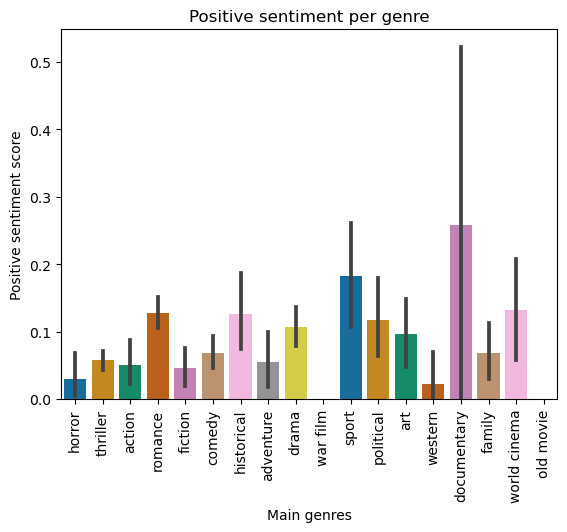

In [64]:
ax=sns.barplot(movies, x="Movie_main_genre", y="pos_sentiment",palette='colorblind')
plt.xticks(rotation=90)
ax.set(xlabel="Main genres",ylabel="Positive sentiment score",title="Positive sentiment per genre")

/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 23.999999999999986, 'Main genres'),
 Text(24.000000000000014, 0.5, 'Negative sentiment score'),
 Text(0.5, 1.0, 'Negative sentiment per genre')]

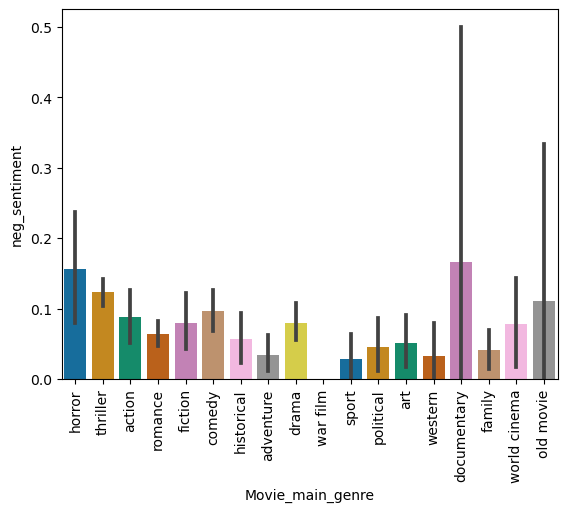

In [65]:
sns.barplot(movies, x="Movie_main_genre", y="neg_sentiment",palette='colorblind')
plt.xticks(rotation=90)
ax.set(xlabel="Main genres",ylabel="Negative sentiment score",title="Negative sentiment per genre")


The two plots confirm our naive assumption:
- Romance movie's titles are associated with higher positive sentiment score.
- Horror movie's titles are associated with higher negative sentiment score.

* Titles in drama and romance genres lean towards positive or neutral sentiments to reflect the emotional and heartfelt nature of the narrative. 
* Horror and thriller titles frequently incorporate negative sentiments to create an air of suspense, mystery, or fear. The goal is to intrigue and elicit an emotional response. Example: "Psycho"
* Sport movie titles often carry positive sentiments to reflect the themes of triumph, teamwork, and personal growth. Positive sentiments contribute to the inspirational and uplifting nature of these films.
* Titles associated with world cinema often carry positive sentiments, emphasizing the diverse and enriching cultural experiences depicted in these films. 
* Political movie titles may carry positive sentiments, particularly if the focus is on inspiring change, highlighting positive political movements, or celebrating leaders and figures who made a positive impact.
* Historical movie titles may carry positive sentiments, emphasizing the inspiration from historical events, heroic figures, and significant moments.
* Fictional movie titles may carry negative sentiments if the focus is on dystopian or dark themes.
* Titles associated with art films often carry positive sentiments, reflecting the artistic and creative nature of these films.

Now we can look at the success indicator for different positive or negative sentiment scores.

/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

<AxesSubplot:xlabel='neg_sentiment', ylabel='Success_indicator'>

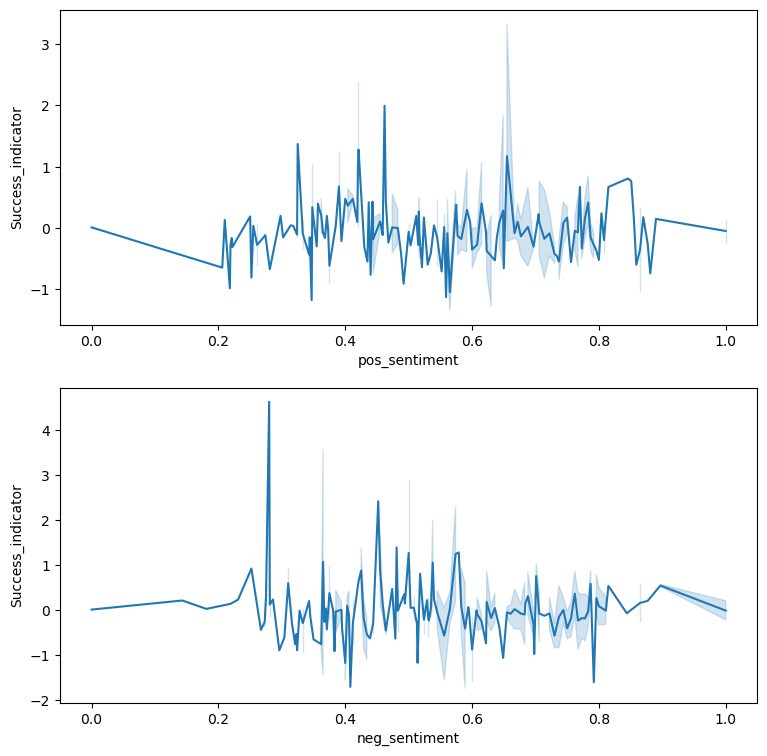

In [66]:
fig,(ax1,ax2)=plt.subplots(2,figsize=(9,9))

sns.lineplot(data=movies,x='pos_sentiment',y='Success_indicator',ax=ax1)
sns.lineplot(data=movies,x='neg_sentiment',y='Success_indicator',ax=ax2)



The sentiment score does not seem to have a significant influence on the success indicator.

## 4.6 - Document Classification



A movie genre classification system was developed through two distinct approaches. 

Initially, vocabulary lists for each genre were generated with the assistance of generative AI. However, it was observed that these lists were more descriptive than containing relevant vocabulary, highlighting their limitations.

To address this, a more robust solution was implemented. A classifier was trained using movie summaries to capture genre-specific vocabulary. The top 200 most frequent words in summaries for each genre were selected to create relevant vocabulary lists. To enhance specificity, words present in more than half of the different genre lists were removed.

The final step involved merging the two dictionaries— the one generated by ChatGPT and the other derived from the summaries, to leverage the strengths of both approaches. Movie titles were subsequently tested against this combined vocabulary for genre classification. To gauge the efficacy of the classification, accuracy and precision metrics were calculated, to indicate how well the model performs in predicting the correct genre for a given movie.

The genre prediction plays a crucial role in our subsequent task of predicting movie success based on titles. Accurate genre predictions contribute to the precision of success predictions, given the significant influence of genre on a movie's reception and popularity. This prediction of genre is going to be useful for the movie success prediction based on titles that we perform afterwards.

In [67]:
# Initial Genre Vocabulary lists generated by Generative AI

action_movie_lexical_field = [
    "Explosive", "Thrilling", "Intense", "Adrenaline", "Stunts",
    "Chase", "Gunfights", "Fight Sequences", "Heroic", "Showdown",
    "Combat", "Escape", "Danger", "High-octane", "Vigilante",
    "Rescue", "Martial Arts", "Suspense", "Explosions", "Tension",
    "Firepower", "Cinematic", "Gritty", "Mission", "Confrontation",
    "Underworld", "Spectacle", "Pursuit", "Tactical", "Revenge",
    "Covert Operations", "Fast-paced", "Adversary", "Urban Warfare",
    "Daring", "Climactic", "Blitzkrieg", "Onslaught", "Skirmish",
    "Vendetta", "Mayhem", "Assault", "Battle", "Clash",
    "Carnage", "Havoc", "Melee", "Rampage", "Battlefront",
    "Ambush", "Siege", "Duel", "Conflict", "Strife",
    "Renegade", "Bravery", "Insurgent", "Fugitive", "Fierce",
    "Bulletstorm", "Demolition", "Sniper", "Crisis", "Tough-as-nails",
    "Hand-to-hand Combat", "Struggle", "Infiltration", "Strategic", "Dynamic",
    "Prowess", "Conspirator", "Flashpoint", "Perseverance", "Sudden",
    "Stealth", "Commando", "Espionage", "Precision", "Vanguard",
    "Reckless", "Hostile", "Combatant", "Intrepid", "Tumult",
    "Audacity", "Escapade", "Surging", "Raucous", "Paragon",
    "Impetus", "Onrush", "Frenetic", "Stalwart", "Incursion",
    "Ruckus", "Zeal", "Vortex", "Upheaval", "Bedlam", "Strain"
]
action_movie_lexical_field = list(set(action_movie_lexical_field))

adventure_movie_lexical_field = [
    "Epic", "Journey", "Quest", "Exploration", "Discovery",
    "Expedition", "Thrilling", "Adventurous", "Quest", "Odyssey",
    "Discovery", "Exploration", "Exhilarating", "Perilous", "Legendary",
    "Daring", "Heroic", "Escapade", "Venture", "Exotic",
    "Discovery", "Challenges", "High-stakes", "Uncharted", "Exploits",
    "Action-packed", "Enigmatic", "Mysterious", "Pioneering", "Unexplored",
    "Unknown", "Explorers", "Voyage", "Daring", "Risks",
    "Questing", "Adrenaline", "Landscapes", "Vast", "Untamed",
    "Wilderness", "Jungle", "Mountainous", "Desert", "Seafaring",
    "Nautical", "High-seas", "Cinematic", "Immersive", "Enthralling",
    "Suspenseful", "Discovery", "Epic-scale", "Monumental", "Undiscovered",
    "Wonder", "Panoramic", "Breathtaking", "Journey", "Escapades",
    "Exploratory", "Unknown", "Uncharted", "Excursion", "High-adventure",
    "Traverse", "Bold", "Questing", "Intriguing", "Trailblazing",
    "Unfolding", "Unraveling", "Mythical", "Enchanted", "Unearth",
    "Quixotic", "Stirring", "Vivid", "Expeditionary", "Bold",
    "Voyaging", "Peril", "Quester", "Forefront", "Endeavor",
    "Pioneering", "Enterprising", "Questing", "Safari", "Epic",
    "Legendary", "Voyager", "Discovery", "Odyssey", "Mythical",
    "Fabled", "Ethereal", "Intrigue", "Vista", "Daring",
    "Fascination", "Enigma", "Intricacy", "Marvel", "Prowess",
    "Pioneer", "Risk-taker", "Challenge", "Adventure-seeker", "Discovery"
]
adventure_movie_lexical_field= list(set(adventure_movie_lexical_field))

art_movie_lexical_field = [
    "Harmony", "Melody", "Symphony", "Concert", "Performance",
    "Masterpiece", "Gallery", "Exhibition", "Artistic", "Creative",
    "Expression", "Innovation", "Aesthetics", "Imagery", "Composition",
    "Rhythm", "Dance", "Ballet", "Opera", "Theatrical",
    "Literature", "Novel", "Poetry", "Prose", "Fiction",
    "Nonfiction", "Verse", "Song", "Lyric", "Genre",
    "Plot", "Character", "Setting", "Narration", "Theme",
    "Tone", "Style", "Classic", "Modern", "Avant-garde",
    "Impressionism", "Surrealism", "Realism", "Abstract", "Expressionism",
    "Symbolism", "Diction", "Sonnet", "Haiku", "Narrative",
    "Symbol", "Allegory", "Dialogue", "Monologue", "Soliloquy",
    "Metaphor", "Simile", "Alliteration", "Personification", "Hyperbole",
    "Irony", "Paradox", "Satire", "Comedy", "Tragedy",
    "Drama", "Performance", "Entertainment", "Spectacle", "Stagecraft",
    "Visuals", "Inspirational", "Collaboration", "Experimentation", "Fusion",
    "Interpretation", "Medium", "Creative", "Author", "Composer",
    "Lyricist", "Choreographer", "Imaginative", "Inspiration", "Enchantment",
    "Intrigue", "Elegance", "Visionary", "Expressive", "Poignant",
    "Evocative", "Captivating", "Resonance", "Emotion", "Atmosphere",
    "Innovative", "Immersive", "Imagination", "Muse", "Compelling",
    "Reflective", "Thought-provoking", "Sensual", "Ethereal", "Timeless"
]
art_movie_lexical_field = list(set(art_movie_lexical_field))

comedy_movie_lexical_field = [
    "Humor", "Laughter", "Comedy", "Hilarious", "Wit",
    "Satire", "Farce", "Spoof", "Parody", "Slapstick",
    "Zany", "Jovial", "Whimsical", "Amusing", "Lighthearted",
    "Witty", "Joke", "Gag", "Chuckle", "Jest",
    "Prank", "Whoopee", "Mischief", "Mirth", "Jest",
    "Quip", "Banter", "Wisecrack", "Irony", "Sarcasm",
    "Puns", "Joviality", "Hilarity", "Comical", "Jocular",
    "Playful", "Jesting", "Fun", "Rib-tickling", "Guffaw",
    "Laughable", "Silly", "Absurd", "Ridiculous", "Eccentric",
    "Quirky", "Eccentricity", "Droll", "Buffoonery", "Antics",
    "Clumsy", "Irreverent", "Giggles", "Merriment", "Jollity",
    "Drollery", "Hilarity", "Grotesque", "Waggish", "Buffoonish",
    "Hijinks", "Foolery", "Ludicrous", "Giggly", "Jesting",
    "Jocund", "Silly", "Ridicule", "Silliness", "Gaiety",
    "Jolly", "Gleeful", "Frolicsome", "Joyful", "Laughing",
    "Giggling", "Cheerful", "Happy", "Merry", "Mirthful",
    "Amused", "Whimsy", "Entertaining", "Playfulness", "Hysterical",
    "Jestful", "Waggishness", "Teasing", "Facetious", "Light-hearted",
    "Chuckler", "Giggler", "Hilarity", "Drollness", "Joking",
    "Gag-filled", "Whimsy", "Amusement", "Jestfulness", "Chuckler",
    "Giggler", "Merriment", "Mirthfulness", "Jestfulness", "Jokiness",
    "Humerous", "Whimsicality", "Playful", "Farcical", "Jocose",
    "Witty", "Irreverent", "Ridiculous", "Ludicrousness", "Waggishness"
]
comedy_movie_lexical_field = list(set(comedy_movie_lexical_field))


drama_movie_lexical_field = [
    "Tragedy", "Conflict", "Emotional", "Relationships", "Struggle",
    "Heartbreak", "Loss", "Tension", "Sacrifice", "Resilience",
    "Triumph", "Betrayal", "Redemption", "Intense", "Character",
    "Strife", "Profound", "Raw", "Impactful", "Cinematic",
    "Journey", "Crisis", "Confrontation", "Moving", "Compelling",
    "Powerful", "Challenge", "Resolution", "Inspiration", "Captivating",
    "Human condition", "Poignant", "Inner conflict", "Dynamics", "Growth",
    "Realism", "Decision", "Reflection", "Ambition", "Desperation",
    "Emotion", "Multidimensional", "Inner turmoil", "Relationship", "Gripping",
    "Soul-stirring", "Unresolved", "Beauty", "Ambiguous", "Unflinching",
    "Introspection", "Life-changing", "Dilemma", "Moral", "Identity",
    "Self-discovery", "Suffering", "Empathy", "Striving", "Ambition",
    "Desperation", "Drama", "Pivotal", "Twists", "Vivid",
    "Depiction", "Immersion", "Affecting", "Exploration", "Sensational",
    "Tragic", "Mysterious", "Dramatic", "Poignant", "Unpredictable",
    "Resonant", "Complicated", "Stunning", "Cinematic", "Masterclass",
    "Human", "Emotionally", "Evocative", "Character", "Raw",
    "Authenticity", "Genuine", "Experiences", "Turbulent", "Searing",
    "Thoughtful", "Brilliance", "Intimate", "Gripping", "Masterclass",
    "Impactful", "Storytelling", "Nuanced", "Potent", "Stirring",
    "Unsettling", "Harsh", "Atmosphere", "Challenging", "Pensive",
    "Soul-searching", "Cinematography", "Exploration", "Realism", "Compelling",
    "Human", "Emotionally", "Turbulent", "Searing", "Impactful",
    "Captivating", "Stunning", "Gripping", "Intricate", "Unpredictable",
    "Soul-stirring", "Emotional", "Resonance", "Complex", "Affecting",
    "Journey", "Character", "Depth", "Cinematic", "Excellence",
    "Awe-inspiring", "Performances", "Compelling", "Dynamics", "Resonant",
    "Gut-wrenching", "Transcendent", "Experience", "Impactful", "Development",
    "Harsh", "Realities", "Ambiguous", "Resolutions", "Soul-searching",
    "Impactful", "Cinematography", "Exploration", "Realism", "Compelling",
    "Human", "Emotionally", "Turbulent", "Searing", "Impactful"
]
drama_movie_lexical_field = list(set(drama_movie_lexical_field))


opinion_political_movie_lexical_field = [
    "Political", "Opinion", "Government", "Power", "Ideology",
    "Activism", "Controversy", "Policy", "Election", "Social",
    "Injustice", "Advocacy", "Leadership", "Corruption", "Debate",
    "Perspective", "Partisanship", "Revolution", "Democracy", "Authoritarianism",
    "Crisis", "Protest", "Civil Liberties", "Public Policy", "Political Drama",
    "Governmental", "Political System", "Reform", "Oppression", "Voices",
    "Resistance", "Diplomacy", "Authority", "Thriller", "Public Opinion",
    "Policy-making", "Climate", "Advocacy", "Propaganda", "Conflict",
    "Allegory", "Corruption", "Movement", "Unrest", "Satire",
    "Activism", "Civil Rights", "Campaign", "Revolution", "Upheaval",
    "Intrigue", "Dissent", "Political Landscape", "Rivalry", "Strategy",
    "Divide", "Decision", "Discontent", "Theater", "Vision",
    "Standoff", "Philosophy", "Insight", "Legacy", "Ethics",
    "Protest", "Critique", "Visionary", "Revolution", "Debate",
    "Dissent", "Thriller", "Strategy", "Protest", "Commentary",
    "Movement", "Revolution", "Upheaval", "Dissent", "Allegory"
]

opinion_political_movie_lexical_field = list(set(opinion_political_movie_lexical_field))

family_friendly_movie_lexical_field = [
    "Adventure", "Fantasy", "Animation", "Family", "Children",
    "Comedy", "Magic", "Friendship", "Wholesome", "Enchanting",
    "Imagination", "Joyful", "Heartwarming", "Animated", "Cartoon",
    "Lighthearted", "Cheerful", "Innocent", "Charming", "Magical",
    "Playful", "Adorable", "Fantasy", "Wonder", "Childhood",
    "Fun", "Entertaining", "Moral", "Colorful", "Laugh",
    "Smile", "Happiness", "Immersive", "Inspiring", "Imaginative",
    "Cute", "Sweet", "Heroic", "Dreamy", "Optimistic",
    "Vibrant", "Whimsical", "Fairy tale", "Excitement", "Inclusive",
    "Heartfelt", "Chuckle", "Feel-good", "Positive", "Caring",
    "Uplifting", "Journey", "Bravery", "Wonderment", "Epic",
    "Spectacle", "Gentle", "Fable", "Clever", "Imaginary",
    "Fanciful", "Cartoonish", "Creative", "Silly", "Fantasy",
    "Adventure", "Humorous", "Wholesome", "Storytelling", "Lively",
    "Innocence", "Values", "Realm", "Kid-friendly", "Adventurous",
    "Wonder-filled", "Animation", "Feature", "Entertaining", "Charm",
    "Moments", "Giggle", "Bright", "Creativity", "Whimsy",
    "Landscape", "Feel-good", "Magic", "Cinematic magic", "Entertainment",
    "Characters", "Fantasy journey"
]
family_friendly_movie_lexical_field = list(set(family_friendly_movie_lexical_field))


fiction_movie_lexical_field = [
    "Science", "Fiction", "Fairy", "Tale", "Fictional",
    "Film", "Medical", "Mythological", "Fantasy", "Sci-Fi",
    "Sword", "Sorcery", "Time", "Travel", "Supernatural",
    "Alien", "Invasion", "Zombie", "Fantasy", "Disaster",
    "Fan", "Film", "Adventure", "Imagination", "Otherworldly",
    "Alternate", "Reality", "Extraterrestrial", "Futuristic", "Speculative",
    "Time-bending", "Magic", "Enchanting", "Epic", "Mythical",
    "Surreal", "Unreal", "Dreamlike", "Mystical", "Paranormal",
    "Magical", "Realism", "Timeless", "Enigmatic", "Fantastical",
    "Supernatural", "Alien", "Worlds", "Parallel", "Universes",
    "Dystopian", "Utopian", "Space", "Exploration", "Interstellar",
    "Time", "Warp", "Parallel", "Realities", "Sorcery",
    "Conjuring", "Mythical", "Beings", "Fable", "Fanciful",
    "Unearthly", "Time", "Paradox", "Extraterrestrial", "Life",
    "Temporal", "Distortion", "Reality-bending", "Immersive", "Unconventional",
    "Astrological", "Galactic", "Time", "Conundrum", "Magical",
    "Creatures", "Parallel", "Dimensions", "Mind-bending", "Ethereal",
    "Phantasmagorical", "Alien", "Abduction", "Time", "Manipulation",
    "Enchanted", "Extraterrestrial", "Visitors", "Spectral", "Mystifying",
    "Astounding", "Phenomenal", "Dimensional", "Travel", "Parallel",
    "Existence", "Cosmic", "Mythopoeic", "Astrophysical", "Enigmatic",
    "Narratives", "Zombified", "Fantasy", "Realms", "Apocalyptic",
    "Time", "Anomaly", "Futuristic", "Technology", "Timeless",
    "Tale", "Unearthly", "Adventures", "Supernatural", "Wonders",
    "Time", "Capsule", "Time", "Dilation", "Alternate",
    "Dimensions", "Timeless", "Wonder", "Galactic", "Explorations",
    "Fanciful", "Journeys", "Sorcerous", "Mythopoeic", "Worlds",
    "Fantastical", "Realities", "Magical", "Adventures", "Time",
    "Loop", "Astrological", "Marvels", "Epic", "Quests",
    "Interdimensional", "Ethereal", "Beauty", "Timeless", "Classic",
    "Astrophysical", "Marvels", "Mythical", "Creatures", "Fantasy",
    "Worlds", "Timeless", "Fantasy", "Cosmic", "Adventures",
    "Imaginary", "Realms", "Galactic", "Quests", "Otherworldly",
    "Phenomena", "Temporal", "Conundrum", "Supernatural", "Beings"
]
fiction_movie_lexical_field = list(set(fiction_movie_lexical_field))


historical_movie_lexical_field = [
    "Short", "Film", "Historical", "Fiction", "Period",
    "Piece", "History", "Biographical", "British", "Empire",
    "Epic", "Cold", "War", "Documentaries", "Biography",
    "Biopic", "Feature", "Netherlands", "World", "II",
    "Gulf", "Movies", "Gladiators", "Drama", "Sponsored",
    "Ancient", "Civilization", "Medieval", "Renaissance", "Revolution",
    "Monarchy", "Colonial", "Exploration", "Discovery", "Warfare",
    "Conflict", "Cultural", "Heritage", "Time", "Era",
    "Costume", "Setting", "Political", "Social", "Cultural",
    "Ceremony", "Tradition", "Ruler", "Empire", "Kingdom",
    "Regime", "Revolt", "Uprising", "Resistance", "Struggle",
    "Conquest", "Dynasty", "Invasion", "Siege", "Alliance",
    "Peasant", "Noble", "Rural", "Urban", "Economy",
    "Trade", "Customs", "Beliefs", "Religion", "Faith",
    "Persecution", "Treaty", "Diplomacy", "Betrayal", "Alliance",
    "Power", "Strife", "Reform", "Change", "Legacy",
    "Artifact", "Archaeology", "Heritage", "Descendants", "Ancestry",
    "Journey", "Exploration", "Trade", "Discovery", "Frontier",
    "Settlement", "Expedition", "Discoverer", "Navigator", "Explorer",
    "Historian", "Chronicler", "Narrative", "Recreation", "Representation"
]
historical_movie_lexical_field = list(set(historical_movie_lexical_field))


horror_movie_lexical_field = [
    "Horror", "Movies", "Natural", "Film", "Sci-fi",
    "Road", "Creature", "Monster", "Slasher", "Thriller",
    "Suspense", "Supernatural", "Paranormal", "Terror", "Fright",
    "Spooky", "Eerie", "Chiller", "Scream", "Nightmare",
    "Dread", "Macabre", "Creepy", "Gory", "Gothic",
    "Dark", "Sinister", "Fear", "Shiver", "Blood-curdling",
    "Bone-chilling", "Hair-raising", "Spine-tingling", "Creepiness", "Startle",
    "Menace", "Apparition", "Phantom", "Wraith", "Specter",
    "Haunting", "Nightmarish", "Freaky", "Unsettling", "Otherworldly",
    "Ghastly", "Frightening", "Eerie", "Ghostly", "Apprehension",
    "Dismay", "Dreadful", "Horrendous", "Horrifying", "Monstrous",
    "Abominable", "Terrifying", "Chilling", "Gruesome", "Repulsive",
    "Ghoul", "Zombie", "Witch", "Vampire", "Werewolf",
    "Demon", "Satanic", "Possession", "Haunted", "Cursed",
    "Malevolent", "Macabre", "Supernatural", "Occult", "Occurrence",
    "Bizarre", "Freakish", "Strange", "Unnatural", "Aberration",
    "Anomaly", "Devilish", "Sinister", "Eldritch", "Fearful",
    "Bloodthirsty", "Deadly", "Fatal", "Grisly", "Grim",
    "Harrowing", "Infernal", "Deathly", "Sinister", "Unholy",
    "Wicked", "Eerie", "Spooky", "Unearthly", "Cemetery",
    "Cryptic", "Ominous", "Petrifying", "Demonic", "Macabre",
    "Mysterious", "Sinister", "Chaos", "Nightfall", "Midnight",
    "Darkness", "Malevolence", "Coven", "Dystopian", "Post-apocalyptic"
]
horror_movie_lexical_field = list(set(horror_movie_lexical_field))


romance_movie_lexical_field = [
    "Romance", "Love", "Passion", "Affection", "Relationship",
    "Heartfelt", "Emotional", "Intimate", "Connection", "Chemistry",
    "Tenderness", "Devotion", "Adoration", "Commitment", "Sentimental",
    "Soulmate", "Desire", "Closeness", "Warmth", "Couples",
    "Heartwarming", "Amorous", "Flirtation", "Courtship", "Endearment",
    "Yearning", "Fondness", "Infatuation", "Serenade", "Lovers",
    "Sweetheart", "Enchantment", "Passionate", "Happiness", "Eternal",
    "Joyful", "Gentle", "Charming", "Sweeping", "Embrace",
    "Whisper", "Breathtaking", "Enamored", "Candlelit", "Romanticism",
    "Cherish", "Connection", "Blissful", "Tender", "Hearts",
    "Lovebird", "Intimacy", "Sentiment", "Swoon", "Elope",
    "Captivating", "Admiration", "Dreamy", "Amour", "Fairy-tale",
    "Honeymoon", "Passionate", "Heartfelt", "Sensual", "Kiss",
    "Dreamy", "Poetic", "Seductive", "Flame", "Lust",
    "Intrigue", "Dreamlike", "Enchanted", "Cinema", "Wooing",
    "Dazzling", "Luminous", "Ephemeral", "Quixotic", "Serendipity",
    "Bliss", "Butterflies", "Giddy", "Infinite", "Adorned",
    "Infatuation", "Charm", "Sincerity", "Gaze", "Whirlwind",
    "Beloved", "Hug", "Giddy", "Infinite", "Amaze",
    "Rendezvous", "Rapture", "Magnetic", "Velvet", "Adorned",
    "Yearn", "Eternal", "Cuddle", "Swept", "Wistful"
]

romance_movie_lexical_field = list(set(romance_movie_lexical_field))

sports_movie_lexical_field = [
    "Sports", "Athletics", "Competition", "Team", "Victory",
    "Champion", "Challenge", "Adversity", "Triumph", "Defeat",
    "Determination", "Training", "Strive", "Achievement", "Rivalry",
    "Mentor", "Underdog", "Inspiration", "Dedication", "Grit",
    "Courage", "Glory", "Conquer", "Passion", "Commitment",
    "Game", "Athlete", "Intensity", "Drive", "Perseverance",
    "Goal", "Win", "Loss", "Struggle", "Motivation",
    "Teamwork", "Spirit", "Endurance", "Sporting", "Event",
    "Stamina", "Challenge", "Vigorous", "Discipline", "Victorious",
    "Courageous", "Thrilling", "Inspire", "Passionate", "Courage",
    "Sweat", "Heart", "Drama", "Intensity", "Achieve",
    "Skill", "Training", "Competitive", "Grit", "Challenge",
    "Determination", "Inspiring", "Athleticism", "Endeavor", "Perseverance",
    "Hardship", "Conquest", "Prowess", "Rival", "Tribulation",
    "Camaraderie", "Adrenaline", "Gladiatorial", "Confrontation", "Striving",
    "Tenacity", "Spectacle", "Showdown", "Pinnacle", "Courage",
    "Gutsy", "Strategic", "Stalwart", "Steadfast", "Tenacious",
    "Valiant", "Resilient", "Unyielding", "Indomitable", "Fierce",
    "Adversarial", "Overcome", "Aspiration", "Clash", "Match",
    "Exertion", "Physicality", "Rigorous", "Pursuit", "Ambition",
    "Resolve", "Test", "Contest", "Journey", "Conqueror"
]

sports_movie_lexical_field = list(set(sports_movie_lexical_field))


thriller_movie_lexical_field = [
    "Thriller", "Suspense", "Mystery", "Tension", "Intensity",
    "Plot", "Drama", "Action", "Intrigue", "Crisis",
    "Conspiracy", "Enigma", "Cliffhanger", "Unexpected", "Adrenaline",
    "Chase", "Danger", "Sudden", "Panic", "Foreboding",
    "Gripping", "Eerie", "Menacing", "Cryptic", "Unsettling",
    "Cinematic", "Riddle", "Puzzling", "Mind-bending", "Nail-biting",
    "Sinister", "Chilling", "Dark", "Compelling", "Mysterious",
    "Suspicious", "Twist", "Turn", "Puzzle", "Psychological",
    "Dread", "Anxiety", "Mistrust", "Paranoia", "Obscure",
    "Cunning", "Surprise", "Sneak", "Taut", "Concealed",
    "Fear", "Prowl", "Heart-pounding", "Enigmatic", "Cryptic",
    "Doubt", "Apprehension", "Maze", "Risky", "Revelation",
    "Ominous", "Creepy", "Peril", "Obsession", "Hidden",
    "Reckoning", "Menace", "Covert", "Clandestine", "Uncertainty",
    "Prelude", "Unveil", "Unpredictable", "Challenging", "Intricate",
    "Decipher", "Investigate", "Neurotic", "Stalking", "Sleuth",
    "Mistrust", "Enshroud", "Envelop", "Ambiguity", "Sly",
    "Furtive", "Shadowy", "Stealthy", "Provocative", "Piquant",
    "Thrill", "Forewarning", "Uncanny", "Edgy", "Risky",
    "Edgy", "Risk", "Jolt", "Pulse-pounding", "Uncanny",
    "Obscure", "Mysterious", "Secretive", "Unrevealed", "Veiled",
    "Veiled", "Covered", "Masked", "Hidden", "Cloaked"
]
thriller_movie_lexical_field = list(set(thriller_movie_lexical_field))


western_movie_lexical_field = [
    "Western", "Cowboy", "Frontier", "Saloon", "Gunfight",
    "Outlaw", "Sheriff", "Ranch", "Dusty", "Horse",
    "Cattle", "Wagon", "Desert", "Spur", "Saddle",
    "Lasso", "Rodeo", "Wrangler", "Trail", "Vigilante",
    "Bandit", "Posse", "Pioneer", "Gold rush", "Prospector",
    "Marshal", "Duel", "Chase", "Prairie", "Homestead",
    "Stagecoach", "Stampede", "Corral", "Stetson", "Cattle drive",
    "Campfire", "Revolver", "Saloon", "Desperado", "High noon",
    "Shootout", "Gunslinger", "Wasteland", "Chaps", "Frontiersman",
    "Cactus", "Boomtown", "Sarsaparilla", "Bounty", "Wrangle",
    "Dust", "Canyon", "Sunset", "Homesteader", "Grit",
    "Range", "Buckaroo", "Rustler", "Wrangling", "Marshal",
    "Lawman", "Varmint", "Vaquero", "Giddy-up", "Hooves",
    "Bonanza", "Chisholm", "Draw", "Buffalo", "Stallion",
    "Hideout", "Land rush", "Desperado", "Sunrise", "Pecos",
    "Roundup", "Prospect", "Tumbleweed", "Roaming", "Sierra",
    "Homestead", "Cattleman", "Pony", "Nomad", "Sunshine",
    "Leather", "Outlawed", "Drover", "Sunset", "Wanderer",
    "Wrangler", "Wrangle", "Wagon train", "Lone", "Brand",
    "Bounty", "Hoedown", "Buckskin", "Gambler", "Poker",
    "Frontierswoman", "Drovers", "Galloping", "Desperado", "Rifle",
    "Stagecoach", "Gold mine", "Lariat", "Homestead"
]

western_movie_lexical_field = list(set(western_movie_lexical_field))


world_cinema_lexical_field = [
    "Global", "Journey", "Cultural", "Nomad", "Odyssey",
    "Heritage", "Melting Pot", "Harmony", "Bridges", "Voyage",
    "Diversity", "Mosaic", "Parallel", "Discovery", "Tapestry",
    "Unity", "Exploration", "Fusion", "Epic", "Exotic",
    "Quest", "Multicultural", "Synchronicity", "Cinematic", "Panorama",
    "Vista", "Intersection", "Cinéaste", "Nomadic", "Transcendent",
    "Auteur", "Collage", "Mélange", "Inclusive", "Globalization",
    "Spectrum", "Confluence", "Synchrony", "Interwoven", "Metamorphosis",
    "Chorus", "Pan-global", "Interplay", "Mélange", "Juxtapose",
    "Crossover", "Intersection", "Panoramic", "Inclusivity", "Bicultural",
    "Multiregional", "Multinational", "Worldview", "Cinephile", "Polyglot",
    "Peregrination", "Folklore", "Intercultural", "Anthology", "Citizen",
    "Amalgamation", "Pluralistic", "Amalgamation", "Nomadic", "Eclectic",
    "Transnational", "Anthology", "Polyglot", "Cosmopolitan", "Synthesis",
    "Farrago", "Odyssey", "Tapestry", "Diversity", "Cinematic",
    "Epic", "Crossover", "Synchrony", "Cultural", "Melting Pot",
    "Voyage", "Intersection", "Cinéaste", "Transcendent", "Auteur",
    "Collage", "Mélange", "Globalization", "Spectrum", "Confluence",
    "Chorus", "Pan-global", "Interplay", "Juxtapose", "Crossover",
    "Intersection", "Panoramic", "Inclusivity", "Multiregional", "Multinational",
    "Worldview", "Cinephile", "Folklore", "Anthology", "Polyglot"
]

world_cinema_lexical_field = list(set(world_cinema_lexical_field))

war_film_lexical_field = [
    "War", "Conflict", "Battle", "Combat", "Struggle",
    "Soldier", "Warrior", "Troop", "Deployment", "Campaign",
    "Trench", "Frontline", "Barracks", "Armored", "Battleground",
    "Casualty", "Heroism", "Resilience", "Victory", "Defeat",
    "Warfare", "Strategy", "Tactics", "Firepower", "Mobilization",
    "Alliance", "Invasion", "Occupation", "Hostility", "Battlefield",
    "Mission", "Operation", "Strife", "Siege", "Conquest",
    "Ceasefire", "Truce", "Reconnaissance", "Muster", "Nuclear",
    "Destruction", "Conflict zone", "Conscription", "Draft", "Allied",
    "Axis", "Warlord", "Insurgency", "Resistance", "Paratrooper",
    "Guerrilla", "Surrender", "Occupied", "Infiltration", "Shellshock",
    "Armistice", "Militant", "Enlistment", "Crisis", "Retaliation",
    "Rebellion", "Commander", "Martyr", "Peacekeeper", "Holocaust",
    "Infantry", "Cavalry", "Bunker", "Air raid", "Navy",
    "Aerial", "Landmine", "Missile", "Barricade", "Muster",
    "Doctrine", "Rations", "Atrocity", "Civilian", "Collateral",
    "Mobilize", "Veteran", "Paramilitary", "Neutrality", "Deterrence",
    "Warplane", "Nuclear fallout", "Disarmament", "Tragedy", "Genocide",
    "Foreign legion", "Siege", "Rifle", "Artillery", "Outpost",
    "Munitions", "Draft", "Naval", "Deployment", "Landmark",
    "Allied", "Prisoner", "Detainee", "Invasion", "Mobilization",
    "Retreat", "Conquer", "Counterattack", "Insurgency", "Outgunned"
]

war_film_lexical_field = list(set(war_film_lexical_field))


In [71]:
# Lemmatize and lower vocabulary lists from chatGPT

vocab={"action": [lemmatizer.lemmatize(word.lower()) for word in action_movie_lexical_field],
            "adventure": [lemmatizer.lemmatize(word.lower()) for word in adventure_movie_lexical_field], 
            "art": [lemmatizer.lemmatize(word.lower()) for word in art_movie_lexical_field],
            "comedy":[lemmatizer.lemmatize(word.lower()) for word in comedy_movie_lexical_field], 
            "drama": [lemmatizer.lemmatize(word.lower()) for word in drama_movie_lexical_field], 
            "political": [lemmatizer.lemmatize(word.lower()) for word in opinion_political_movie_lexical_field],
            "family": [lemmatizer.lemmatize(word.lower()) for word in family_friendly_movie_lexical_field], 
            "fiction": [lemmatizer.lemmatize(word.lower()) for word in fiction_movie_lexical_field], 
            "historical": [lemmatizer.lemmatize(word.lower()) for word in historical_movie_lexical_field], 
            "horror": [lemmatizer.lemmatize(word.lower()) for word in horror_movie_lexical_field], 
            "romance": [lemmatizer.lemmatize(word.lower()) for word in romance_movie_lexical_field],
            "sport": [lemmatizer.lemmatize(word.lower()) for word in sports_movie_lexical_field], 
            "thriller": [lemmatizer.lemmatize(word.lower()) for word in thriller_movie_lexical_field], 
            "western": [lemmatizer.lemmatize(word.lower()) for word in western_movie_lexical_field],
            "world cinema": [lemmatizer.lemmatize(word.lower()) for word in world_cinema_lexical_field], 
            "war film": [lemmatizer.lemmatize(word.lower()) for word in war_film_lexical_field]
}

In [73]:
# Function to filter stop words
def filter_stop_words(text_list):
    # Initialize an empty list to store filtered words
    filtered_list = []
    # List of words to be retained despite being stopwords or punctuation
    rest=["'s",'``',"''"]
    # Iterate through each word in the input text list
    for word in text_list:
        # Check if the word is not a stopword, not a punctuation, and not in the 'rest' list, add the word to the filtered list
        if word.casefold() not in stop_words and  word.casefold() not in punctuation and word.casefold() not in rest:
                filtered_list.append(word)

    return(filtered_list)

In [76]:

#Cut the text document as a list of 42,306 movies

with open("Data/plot_summaries.txt", "r", encoding='utf-8') as file:
    content = file.read()

# Split the content into entries based on the tab character
entries = content.split('\n')

# Create a list to store summaries
docs = []
titles=[]

# Iterate through entries and extract summaries
for entry in entries:
    if entry:  # Skip empty lines
        # Split each entry based on the tab character
        parts = entry.split('\t', 1)

        # Check if the entry has at least two parts (ID and summary)
        if len(parts) == 2:
            title, summary = parts
            docs.append(summary)
            titles.append(int(title))



In [77]:
# creating a dataframe with two columns: 'summary' and 'Wikipedia_movie_ID

data=pd.DataFrame({'summary':docs,'Wikipedia_movie_ID':titles})
data.head()

,summary,Wikipedia_movie_ID
0,"Shlykov, a hard-working taxi driver and Lyosha...",23890098
1,The nation of Panem consists of a wealthy Capi...,31186339
2,Poovalli Induchoodan is sentenced for six yea...,20663735
3,"The Lemon Drop Kid , a New York City swindler,...",2231378
4,Seventh-day Adventist Church pastor Michael Ch...,595909


In [78]:
# 

data_preprocessed=pd.read_csv('Data/movies_preprocessed.csv')
data_preprocessed.head()

,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Character_in_title
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['United States of America'],thriller,"['Akooshay', 'Lieutenant Melanie Ballard', 'De...",False
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,['United States of America'],thriller,"['Police Officer', 'Reporter', 'FBI Profiler R...",False
2,2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,['United Kingdom'],thriller,NaN,NaN
3,3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,['South Africa'],family,['Morgana'],False
4,4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['United States of America'],art,['Roger Grant AKA Alexander'],False


In [79]:
# Merge the summary and the movies dataset on Wikipedia_movie_ID and keep only movie genres and summaries

data2=data.merge(data_preprocessed,on=['Wikipedia_movie_ID'],how='inner')
data2=data2[['Movie_main_genre','summary']]
data2['Movie_main_genre'].astype=str
data2.head()

,Movie_main_genre,summary
0,action,The nation of Panem consists of a wealthy Capi...
1,comedy,"The Lemon Drop Kid , a New York City swindler,..."
2,thriller,Seventh-day Adventist Church pastor Michael Ch...
3,thriller,The president is on his way to give a speech. ...
4,thriller,"{{plot}} The film opens in 1974, as a young gi..."


To mitigate the risk of data leakage in the genre prediction task, we made the decision to exclude information related to PERSON and ORGANISATION from the summary genre vocabulary dictionnary. Including such information could introduce bias and inadvertently leak information about the genre into the model.

In [82]:
# create a list of vocabulary for one genre using the summaries

def liste_vocab(dataframe, genre):
    # Filter the dataframe based on the specified genre
    genre_df = dataframe[dataframe['Movie_main_genre'] == genre]
    
    # Extract summaries for the specified genre
    summaries = list(genre_df['summary'])
    print(len(summaries))  # Print the number of summaries for the given genre

    SUMMARY = []  # List to store the vocabulary

    for i in range(0, len(summaries)):
        sentence = summaries[i]

        # Preprocessing steps
        # Convert to lowercase
        sentence = sentence.lower()
        # Tokenize
        summary_list = word_tokenize(sentence)
        # Remove stopwords
        filtered_summary_list = filter_stop_words(summary_list)

        # Named Entity Recognition (NER)
        # Tagging parts of speech
        pos_tags = nltk.pos_tag(filtered_summary_list)
        # Chunking for NER
        ne_tree = nltk.ne_chunk(pos_tags)

        # Access named entities and their labels
        ne_label = []
        for subtree in ne_tree:
            if isinstance(subtree, nltk.Tree):  # Check if the subtree is a named entity
                ne_label.append(subtree.label())
            else:
                ne_label.append('OUPS')  # Placeholder for non-named entities

        # Remove words associated with organizations and persons
        filtered_summary_list = [word for word, label in zip(filtered_summary_list, ne_label) if label not in ('ORGANIZATION', 'PERSON')]

        # Add new words to the vocabulary
        SUMMARY += filtered_summary_list

    # Lemmatize the vocabulary
    lemmatizer = WordNetLemmatizer()
    SUMMARY_LEM = [lemmatizer.lemmatize(word) for word in SUMMARY]

    # Count the frequency of each word
    word_frequency = Counter(SUMMARY_LEM)

    # Get the 200 most common words
    words_only = [word for word, frequency in word_frequency.most_common(200)]

    return words_only

In [83]:
# Initialize an empty dictionary to store vocabulary lists for each genre
Vocab={}

# Iterate through unique genres in the 'Movie_main_genre' column of the 'data2' DataFrame
for genre in data2.Movie_main_genre.unique():
    
    # Generate a vocabulary list for the current genre, add the list to the dictionary with the genre as the key
    Vocab[genre]=liste_vocab(data2,genre)


886
1683
4970
2306
2147
63
773
922
540
333
590
134
300
503
938
213
115
497
56


In [84]:
# Get rid of words that appear in half of the different vocabulary lists

# Count the frequency of each word across all genres
all_words = [word for genre_words in Vocab.values() for word in genre_words]
word_counts = Counter(all_words)

# Identify words that are present in more than half of the genres
threshold = len(Vocab) / 2
common_words = [word for word, count in word_counts.items() if count > threshold]

# Create a new vocabulary list without these common words
filtered_Vocab = {genre: [word for word in words if word not in common_words] for genre, words in Vocab.items()}

# Display the new filtered vocabulary by genre
for genre, words in filtered_Vocab.items():
    print(f"{genre}: {words}")

action: ['gang', 'gun', 'force', 'shoot', 'jake', 'captain', 'team', 'soldier', 'officer', 'mission', 'shot', 'battle', 'horse', 'killing', 'train', 'ride', 'ship', 'rescue', 'army', 'fire', 'sheriff', 'gold', 'agent', 'billy', 'crew', 'save', 'indian', 'german', 'japanese', 'leader', 'behind', 'member', 'plane', 'guard', 'taken', 'manages', 'tom', 'land', 'using', 'led', 'wounded', 'general', 'island', 'join', 'water', 'joe', 'prison', 'former', 'despite', 'body', 'camp', 'though', 'captured', 'able', 'use', 'ben', 'agrees', 'cross', 'part', 'arrive', 'drive', 'race', 'face', 'steal', 'power', 'open', 'harry', 'including']
comedy: ['team', 'dr.', 'company', 'sex', 'win', 'harry', 'decide', 'girlfriend', 'student', 'including', 'bob', 'everyone', 'george', 'instead', 'high', 'real', 'band', 'former', 'thing', 'relationship', 'danny', 'plot', 'agrees', 'member', 'kid', 'best', 'despite', 'save', 'arrive', 'hotel', 'parent', 'part', 'good', 'called', 'business', 'accidentally', 'open', '

In [85]:
print(f"Common Words Deleted: {common_words}")

Common Words Deleted: ['one', 'take', 'men', 'back', 'find', 'two', 'go', 'kill', 'get', 'man', 'tell', 'town', 'killed', 'make', 'return', 'father', 'film', 'however', 'help', 'friend', 'try', 'fight', 'attack', 'new', 'life', 'escape', 'also', 'time', 'way', 'order', 'day', 'come', 'group', 'later', 'attempt', 'end', 'see', 'begin', 'death', 'war', 'wife', 'first', 'give', 'brother', 'set', 'son', 'old', 'home', 'night', "n't", 'away', 'woman', 'run', 'leave', 'meet', 'head', 'plan', 'year', 'american', 'car', 'young', 'police', 'turn', 'another', 'named', 'money', 'next', 'soon', 'decides', 'family', 'want', 'boy', 'arrives', 'meanwhile', 'three', 'dead', 'stop', 'hand', 'house', 'eventually', 'fall', 'city', 'leaf', 'local', 'love', 'show', 'along', 'world', 'start', 'must', 'work', 'lead', 'well', 'say', 'last', 'john', 'left', 'know', 'place', 'state', 'story', 'refuse', 'leaving', 'would', 'daughter', 'asks', 'together', 'upon', 'still', 'becomes', 'several', 'child', 'finally',

In [86]:
# Fuse the two lists of vocabulary with the key genre 

merged_vocab = {genre: list(set(filtered_Vocab.get(genre, []) + vocab.get(genre, []))) for genre in set(filtered_Vocab) | set(vocab)}

In [87]:
# Print the length of each vocabulary list 

for genre, words in merged_vocab.items():
    print(f"{genre}: (Length: {len(words)})")

documentary: (Length: 117)
drama: (Length: 162)
art: (Length: 174)
political: (Length: 124)
family: (Length: 151)
porn: (Length: 98)
thriller: (Length: 161)
romance: (Length: 159)
historical: (Length: 156)
fiction: (Length: 170)
old movie: (Length: 80)
world cinema: (Length: 126)
action: (Length: 165)
western: (Length: 172)
sport: (Length: 176)
war film: (Length: 201)
horror: (Length: 176)
comedy: (Length: 156)
adventure: (Length: 164)


In [88]:
# Lemmatize and lower each movie name and create a new column 'Lemmatized_movie_name'

movies['Lemmatized_movie_name'] = movies['Movie_name'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x.lower())]))
Titles = movies['Lemmatized_movie_name'].tolist()

In [89]:
def classify_document(document, vocabulary_lists):
    # Combine all sentences in the document into one string and convert to lowercase
    document_text = ' '.join(document).lower()

    # Initialize an empty list to store categories
    cat=[]

    # Iterate through each category and its corresponding vocabulary list, and through each word in the vocabulary list
    for category, word_list in vocabulary_lists.items():
        for word in word_list:
            # Check if the word is present in the document text and if found, add to the list
            if word in document_text:
                cat.append(category)
    return cat

In [90]:
def assign_genre(title, genre_words_dict):
    # Initialize variables to track the maximum match and the assigned genre
    max_match = 0
    assigned_genre = 'Unclassified'

    # Iterate through each genre and its corresponding vocabulary list
    for genre, genre_words in genre_words_dict.items():
        # Calculate the number of matching words between the title and the genre's vocabulary list
        match_count = sum(word in title for word in genre_words)

        # Update the assigned genre if the current genre has more matches
        if match_count > max_match:
            max_match = match_count
            assigned_genre = genre

    print(f'Title: "{title}" is classified in "{assigned_genre}"')    

    # Return the final assigned genre for the given title
    return assigned_genre

In [91]:
# With vocab dataframe (the first one, from chatGPT)

# Assign genre to each title
predicted_genre = [assign_genre(title, vocab) for title in Titles]

# Count films classified by categories
film_genre_counts = {genre: predicted_genre.count(genre) for genre in set(predicted_genre)}

# Display the number of films classified for each category
for genre, count in film_genre_counts.items():
    print(f'Number of films classified in the "{genre}" genre: {count}')

Title: "army of darkness" is classified in "horror"
Title: "blue velvet" is classified in "romance"
Title: "buffy the vampire slayer" is classified in "horror"
Title: "batman return" is classified in "thriller"
Title: "citizen kane" is classified in "world cinema"
Title: "the evil dead" is classified in "Unclassified"
Title: "escape from new york" is classified in "action"
Title: "eye wide shut" is classified in "Unclassified"
Title: "evil dead ii" is classified in "historical"
Title: "fearless" is classified in "horror"
Title: "four wedding and a funeral" is classified in "comedy"
Title: "galaxy quest" is classified in "adventure"
Title: "heather" is classified in "Unclassified"
Title: "the rocky horror picture show" is classified in "horror"
Title: "raging bull" is classified in "Unclassified"
Title: "star trek : generation" is classified in "historical"
Title: "the rock" is classified in "Unclassified"
Title: "the graduate" is classified in "Unclassified"
Title: "taxi driver" is cla

In [92]:
# With merged_vocab dataframe (trained on summaries)

# Assign genre to each title
predicted_genre = [assign_genre(title, merged_vocab) for title in Titles]

# Count films classified by categories
film_genre_counts = {genre: predicted_genre.count(genre) for genre in set(predicted_genre)}

# Display the number of films classified for each category
for genre, count in film_genre_counts.items():
    print(f'Number of films classified in the "{genre}" genre: {count}')

Title: "army of darkness" is classified in "horror"
Title: "blue velvet" is classified in "documentary"
Title: "buffy the vampire slayer" is classified in "documentary"
Title: "batman return" is classified in "documentary"
Title: "citizen kane" is classified in "world cinema"
Title: "the evil dead" is classified in "horror"
Title: "escape from new york" is classified in "documentary"
Title: "eye wide shut" is classified in "documentary"
Title: "evil dead ii" is classified in "historical"
Title: "fearless" is classified in "thriller"
Title: "four wedding and a funeral" is classified in "documentary"
Title: "galaxy quest" is classified in "documentary"
Title: "heather" is classified in "Unclassified"
Title: "the rocky horror picture show" is classified in "documentary"
Title: "raging bull" is classified in "documentary"
Title: "star trek : generation" is classified in "documentary"
Title: "the rock" is classified in "art"
Title: "the graduate" is classified in "documentary"
Title: "taxi 

In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

genres = movies['Movie_main_genre'].unique()
actual_genres = movies['Movie_main_genre'].tolist()

# Calculate precision, recall, and F1 score for each genre (assuming a binary classification problem)
accuracy = accuracy_score(actual_genres, predicted_genre)
# Calculate precision, recall, and F1 score for each genre
precision = precision_score(actual_genres, predicted_genre, average=None)
recall = recall_score(actual_genres, predicted_genre, average=None)
f1_score = f1_score(actual_genres, predicted_genre, average=None)

# Calculate overall accuracy
overall_accuracy = accuracy_score(actual_genres, predicted_genre)
print(f'Overall Accuracy: {overall_accuracy:.2f}')

# Print classification report
print(classification_report(actual_genres, predicted_genre))

Overall Accuracy: 0.05
              precision    recall  f1-score   support

Unclassified       0.00      0.00      0.00         0
      action       0.03      0.01      0.01       137
   adventure       0.08      0.11      0.09        72
         art       0.07      0.10      0.08        78
      comedy       0.15      0.01      0.01       266
 documentary       0.00      0.33      0.00         6
       drama       0.11      0.05      0.07       288
      family       0.08      0.11      0.10        88
     fiction       0.21      0.09      0.13       116
  historical       0.05      0.04      0.04        94
      horror       0.21      0.14      0.17        57
   old movie       0.00      0.00      0.00         5
   political       0.07      0.02      0.04        85
        porn       0.00      0.00      0.00         0
     romance       0.44      0.05      0.09       453
       sport       0.15      0.09      0.12        65
    thriller       0.47      0.04      0.07       740
    

/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Clarisse/anaconda3/envs/a

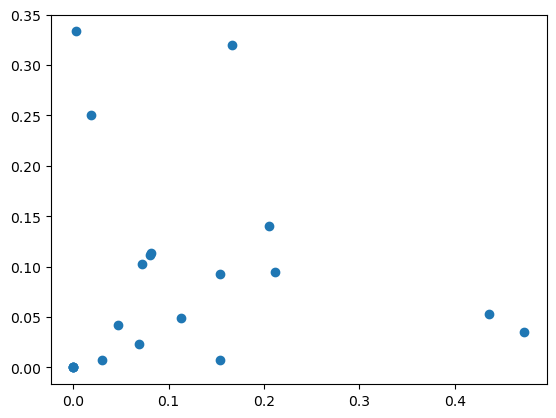

In [95]:
# plot precision recall curve

plt.scatter(precision, recall)

Conclusion : Title-based genre prediction remains a challenging endeavor...

The accuracy of our model remains low : 6%, with a precision of 29%. We can see that some genres are predicted more or less efficicently, for instance romanceand thriller movies seems to be better predicted, while adventure, documentary or world-cinema are are to predict. 

Movie titles are designed with the intention of catching attention, evoking curiosity, and providing a glimpse into the theme of the movie. However, they might not always encapsulate the intricate details and nuances of a genre. 

Titles are inherently concise, aiming to be memorable and intriguing. This brevity often leads to abstractness and ambiguity, making it challenging to extract relevant genre-related information. Titles offer only a glimpse of a movie's content, omitting crucial details such as character dynamics, plot twists, and thematic descriptions.  Titles may be interpreted in various ways, leading to diverse genre predictions. It not possible to draw universal criterion for genre classification : many movies blur genre boundaries, embracing a mix of elements from various genres. Titles for such films may not neatly fit into specific  genre categories, making accurate predictions elusive. 

We also know that many titles only include information such as protagonists names, places or oragnisations, which can not be predicted through our vocabulary lists.

The absence of comprehensive information restricts the predictive power of titles alone. Additional contextual information, such as summaries or even viewer reviews, might be crucial for enhancing the accuracy of genre predictions. 

# 5 - Prediction

To be continued